In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
import wandb

In [ ]:
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: johnced to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
config = {
    "project": "cnn_mnist",
    "entity": None,            # set your wandb username/team if desired
    "epochs": 15,
    "batch_size": 64,
    "lr": 0.001,
    "seed": 42,
    'use_augmentation': False,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# You can call wandb.login() earlier if you haven't set env var.
wandb.init(project=config["project"], config=config)
cfg = wandb.config

# ------------------------------
# Data loaders (MNIST)
# ------------------------------
torch.manual_seed(cfg.seed)

## Experiment 1

1. Check current model size - given in original notebook
2. Check image in paint and tentatively around 7 pixels can capture the edges. So, RF is 7.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = F.relu(self.conv7(x))
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

/tmp/ipython-input-3267201574.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
# Requires: torch
import torch
import torch.nn as nn
import math
from collections import OrderedDict

def _to_2tuple(x):
    if isinstance(x, tuple):
        return x
    return (x, x)

def layer_info(layer):
    """Return (k, s, p, d, type) for conv/pool layers or None."""
    if isinstance(layer, nn.Conv2d):
        k = _to_2tuple(layer.kernel_size)
        s = _to_2tuple(layer.stride)
        p = _to_2tuple(layer.padding)
        d = _to_2tuple(layer.dilation)
        return dict(type='conv', k=k, s=s, p=p, d=d, out_channels=layer.out_channels)
    if isinstance(layer, nn.MaxPool2d) or isinstance(layer, nn.AvgPool2d):
        k = _to_2tuple(layer.kernel_size)
        s = _to_2tuple(layer.stride or layer.kernel_size)
        p = _to_2tuple(layer.padding or 0)
        d = (1,1)
        return dict(type='pool', k=k, s=s, p=p, d=d)
    return None

def analyze_receptive_field(model, input_size=(1, 28, 28), batch_size=1):
    """
    Prints receptive field analysis for model layers.
    input_size: (C, H, W)
    """
    C, H, W = input_size
    # initial values
    rf_h = 1
    rf_w = 1
    jump_h = 1
    jump_w = 1
    start_h = 0.5
    start_w = 0.5

    cur_h, cur_w = H, W

    print(f"{'layer':30} {'type':6} {'out_ch':6} {'k':9} {'s':9} {'p':9} {'out(HxW)':10} {'RF(HxW)':12} {'jump':8} {'start':12}")
    print("-"*120)

    # walk modules in order (skip top-level container)
    idx = 0
    for name, layer in model.named_modules():
        # skip the top-level module itself
        if name == "":
            continue
        info = layer_info(layer)
        if info is None:
            continue

        idx += 1
        typ = info['type']
        k_h, k_w = info['k']
        s_h, s_w = info['s']
        p_h, p_w = info['p']
        d_h, d_w = info['d']

        # effective kernel size with dilation
        eff_kh = d_h * (k_h - 1) + 1
        eff_kw = d_w * (k_w - 1) + 1

        # output spatial size formula: floor((in + 2p - dilation*(k-1)-1)/stride + 1)
        out_h = math.floor( (cur_h + 2*p_h - d_h*(k_h-1) - 1) / s_h + 1 )
        out_w = math.floor( (cur_w + 2*p_w - d_w*(k_w-1) - 1) / s_w + 1 )

        # receptive field update
        new_rf_h = rf_h + (eff_kh - 1) * jump_h
        new_rf_w = rf_w + (eff_kw - 1) * jump_w

        # jump update (how much a 1-px shift in input shifts output center)
        new_jump_h = jump_h * s_h
        new_jump_w = jump_w * s_w

        # center (start) update -- position of the center of the top-left output unit
        new_start_h = start_h + ((eff_kh - 1)/2 - p_h) * jump_h
        new_start_w = start_w + ((eff_kw - 1)/2 - p_w) * jump_w

        out_ch = info.get('out_channels', '-')
        k_str = f"{k_h}x{k_w}"
        s_str = f"{s_h}x{s_w}"
        p_str = f"{p_h}x{p_w}"
        rf_str = f"{int(new_rf_h)}x{int(new_rf_w)}"
        jump_str = f"{new_jump_h}x{new_jump_w}"
        start_str = f"{new_start_h:.2f}x{new_start_w:.2f}"

        print(f"{name:30} {typ:6} {str(out_ch):6} {k_str:9} {s_str:9} {p_str:9} {str(out_h)+'x'+str(out_w):10} {rf_str:12} {jump_str:8} {start_str:12}")

        # set for next iteration
        rf_h, rf_w = new_rf_h, new_rf_w
        jump_h, jump_w = new_jump_h, new_jump_w
        start_h, start_w = new_start_h, new_start_w
        cur_h, cur_w = out_h, out_w

    print("-"*120)
    print(f"Final output spatial size: {cur_h} x {cur_w}")
    print(f"Final receptive field: {int(rf_h)} x {int(rf_w)}")
    print(f"Final cumulative stride (jump): {jump_h} x {jump_w}")
    print(f"Center of top-left output unit relative to input pixel (0-index approx): {start_h:.2f} , {start_w:.2f}")


In [ ]:
model = Net()
analyze_receptive_field(model, input_size=(1, 28, 28))

layer                          type   out_ch k         s         p         out(HxW)   RF(HxW)      jump     start       
------------------------------------------------------------------------------------------------------------------------
conv1                          conv   32     3x3       1x1       1x1       28x28      3x3          1x1      0.50x0.50   
conv2                          conv   64     3x3       1x1       1x1       28x28      5x5          1x1      0.50x0.50   
pool1                          pool   -      2x2       2x2       0x0       14x14      6x6          2x2      1.00x1.00   
conv3                          conv   128    3x3       1x1       1x1       14x14      10x10        2x2      1.00x1.00   
conv4                          conv   256    3x3       1x1       1x1       14x14      14x14        2x2      1.00x1.00   
pool2                          pool   -      2x2       2x2       0x0       7x7        16x16        4x4      2.00x2.00   
conv5                          c

In [ ]:
wandb.watch(model, log="all", log_freq=100)

1. Number of params is very large. Coming from the last few convolutional blocks
2. Will start with #kernels as 8 instead of 32 and gradually increase

In [ ]:
import csv

In [ ]:
class ExperimentLogger:
    """Logger for tracking experiments and results"""

    def __init__(self, experiment_name):
        self.experiment_name = experiment_name
        self.log_file = f"experiment_log_{experiment_name}.csv"
        self.results = []
        self.create_log_file()

    def create_log_file(self):
        """Create CSV file with headers"""
        headers = ['Experiment', 'Model', 'Total_Params', 'Train_Acc', 'Val_Acc',
                  'Train_Loss', 'Val_Loss', 'Epochs', 'Best_Epoch', 'Has_BN',
                  'Has_Dropout', 'Has_GAP', 'Has_FC', 'Learning_Rate', 'Scheduler',
                  'Data_Augmentation', 'Comments']

        with open(self.log_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(headers)

    def log_experiment(self, exp_data):
        """Log experiment results"""
        self.results.append(exp_data)
        with open(self.log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(exp_data.values())

    def get_summary(self):
        """Get summary of all experiments"""
        if not self.results:
            return "No experiments logged yet."

        summary = f"\n=== EXPERIMENT SUMMARY ({self.experiment_name}) ===\n"
        summary += f"Total Experiments: {len(self.results)}\n\n"

        for i, result in enumerate(self.results, 1):
            summary += f"Experiment {i}:\n"
            summary += f"  Model: {result['Model']}\n"
            summary += f"  Parameters: {result['Total_Params']:,}\n"
            summary += f"  Best Val Accuracy: {result['Val_Acc']:.2f}%\n"
            summary += f"  Achieved Target (99.4%): {'✓' if result['Val_Acc'] >= 99.4 else '✗'}\n"
            summary += f"  Under 20k params: {'✓' if result['Total_Params'] < 20000 else '✗'}\n\n"

        return summary

In [ ]:
def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
from tqdm import tqdm

In [ ]:
def train(model, device, train_loader, optimizer, epoch, scheduler = None):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

        # Statistics
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        # Update progress bar
        accuracy = 100. * correct / total
        pbar.set_postfix({'Loss': f'{running_loss/(batch_idx+1):.4f}',
                         'Acc': f'{accuracy:.2f}%'})
        wandb.log({"train/epoch_loss": running_loss/(batch_idx+1), "train/epoch_acc": accuracy, "epoch": epoch})

    return running_loss / len(train_loader), accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    accuracy = 100. * correct / len(test_loader.dataset)
    wandb.log({"test_loss": test_loss, "test/epoch_acc": accuracy})

    return test_loss, accuracy

In [ ]:
def train_epoch(model, device, train_loader, optimizer, scheduler=None):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        # Statistics
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        # Update progress bar
        accuracy = 100. * correct / total
        pbar.set_postfix({'Loss': f'{running_loss/(batch_idx+1):.4f}',
                         'Acc': f'{accuracy:.2f}%'})

    wandb.log({"train/epoch_loss": running_loss / len(train_loader), "train/epoch_acc": accuracy})

    return running_loss / len(train_loader), accuracy

def test_epoch(model, device, test_loader):
    """Test for one epoch"""
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    wandb.log({"test_loss": test_loss, "test_acc": accuracy})

    return test_loss, accuracy

In [ ]:
def check_model_requirements(model):
    """Check if model meets requirements"""
    total_params = count_parameters(model)

    # Check for Batch Normalization
    has_bn = any(isinstance(m, nn.BatchNorm2d) for m in model.modules())

    # Check for Dropout
    has_dropout = any(isinstance(m, (nn.Dropout, nn.Dropout2d)) for m in model.modules())

    # Check for Global Average Pooling
    has_gap = any(isinstance(m, (nn.AdaptiveAvgPool2d, nn.AvgPool2d)) for m in model.modules())

    # Check for Fully Connected layers
    has_fc = any(isinstance(m, nn.Linear) for m in model.modules())

    return {
        'total_params': total_params,
        'under_20k': total_params < 20000,
        'has_bn': has_bn,
        'has_dropout': has_dropout,
        'has_gap': has_gap,
        'has_fc': has_fc
    }

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR, StepLR

def run_experiment(model_class, model_name, experiment_name, epochs=15, learning_rate=0.01,
                  scheduler_type='onecycle', use_augmentation=False, dropout_rate=0.1):
    """Run a complete experiment"""

    print(f"\n{'='*60}")
    print(f"Running Experiment: {model_name}")
    print(f"{'='*60}")

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize model
    model = model_class(dropout_rate=dropout_rate).to(device)
    requirements = check_model_requirements(model)

    print(f"\nModel Requirements Check:")
    print(f"  Total Parameters: {requirements['total_params']:,}")
    print(f"  Under 20k params: {'✓' if requirements['under_20k'] else '✗'}")
    print(f"  Has Batch Normalization: {'✓' if requirements['has_bn'] else '✗'}")
    print(f"  Has Dropout: {'✓' if requirements['has_dropout'] else '✗'}")
    print(f"  Has Global Average Pooling: {'✓' if requirements['has_gap'] else '✗'}")
    print(f"  Has Fully Connected Layer: {'✓' if requirements['has_fc'] else '✗'}")

    # Get data loaders
    train_loader, test_loader = get_data_loaders(use_augmentation=use_augmentation)

    # Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Setup scheduler
    if scheduler_type == 'onecycle':
        scheduler = OneCycleLR(optimizer, max_lr=learning_rate*10,
                             epochs=epochs, steps_per_epoch=len(train_loader))
    elif scheduler_type == 'step':
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    else:
        scheduler = None

    # Training loop
    best_val_acc = 0
    best_epoch = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    print(f"\nStarting Training for {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        # Train
        #train_loss, train_acc = train(model, device, train_loader, optimizer,
        #                                  scheduler if scheduler_type == 'onecycle' else None)

        # Test
        #val_loss, val_acc = test(model, device, test_loader)

        train_loss, train_acc = train_epoch(model, device, train_loader, optimizer,
                                          scheduler if scheduler_type == 'onecycle' else None)

        # Test
        val_loss, val_acc = test_epoch(model, device, test_loader)

        # Update scheduler (for step scheduler)
        if scheduler_type == 'step' and scheduler:
            scheduler.step()

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            # Save best model
            torch.save(model.state_dict(), f'best_{model_name.lower()}.pth')

        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Best Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")

    # Final results
    print(f"\n{'='*40}")
    print(f"EXPERIMENT COMPLETED: {model_name}")
    print(f"{'='*40}")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Target Achievement (99.4%): {'✓' if best_val_acc >= 99.4 else '✗'}")
    print(f"Parameter Efficiency (<20k): {'✓' if requirements['under_20k'] else '✗'}")

    # Log experiment
    logger = ExperimentLogger(experiment_name)
    exp_data = {
        'Experiment': len(logger.results) + 1,
        'Model': model_name,
        'Total_Params': requirements['total_params'],
        'Train_Acc': train_accs[-1],
        'Val_Acc': best_val_acc,
        'Train_Loss': train_losses[-1],
        'Val_Loss': val_losses[val_accs.index(max(val_accs))],
        'Epochs': epochs,
        'Best_Epoch': best_epoch,
        'Has_BN': requirements['has_bn'],
        'Has_Dropout': requirements['has_dropout'],
        'Has_GAP': requirements['has_gap'],
        'Has_FC': requirements['has_fc'],
        'Learning_Rate': learning_rate,
        'Scheduler': scheduler_type,
        'Data_Augmentation': use_augmentation,
        'Comments': f"Dropout: {dropout_rate}"
    }
    logger.log_experiment(exp_data)

    return {
        'model': model,
        'best_val_acc': best_val_acc,
        'requirements': requirements,
        'train_history': (train_losses, train_accs, val_losses, val_accs)
    }

In [ ]:
def get_data_loaders(batch_size=64, use_augmentation=False):
  """Get data loaders"""

  torch.manual_seed(1)

  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
  train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  return train_loader, test_loader


In [ ]:
class Small_MNIST1(nn.Module):
    """
    Small CNN Architecture v1
    - Basic efficient design with BN and Dropout
    - Uses Global Average Pooling
    - Target: <20k parameters, >99.4% accuracy
    """

    def __init__(self, dropout_rate=0.1):
        super(Small_MNIST1, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)

        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)

        # Pooling and regularization
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)

        self.conv4 = nn.Conv2d(16, 32, 3, padding=1)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(32, 32, 3, padding=1)

        # Final classification layer
        self.conv6 = nn.Conv2d(32, 10, 3)  # No BN after final conv


    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        # Block 3 & Classification
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))  # 7x7 -> 5x5
        x = x.view(x.size(0), -1)

        return F.log_softmax(x, dim=1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Small_MNIST1().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2           [-1, 16, 28, 28]           1,168
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           2,320
            Conv2d-5           [-1, 32, 14, 14]           4,640
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 32, 7, 7]           9,248
            Conv2d-8             [-1, 10, 5, 5]           2,890
Total params: 20,346
Trainable params: 20,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 0.08
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


In [ ]:
model = Small_MNIST1(dropout_rate=0.1)
analyze_receptive_field(model, input_size=(1, 28, 28))

layer                          type   out_ch k         s         p         out(HxW)   RF(HxW)      jump     start       
------------------------------------------------------------------------------------------------------------------------
conv1                          conv   8      3x3       1x1       1x1       28x28      3x3          1x1      0.50x0.50   
conv2                          conv   16     3x3       1x1       1x1       28x28      5x5          1x1      0.50x0.50   
pool1                          pool   -      2x2       2x2       0x0       14x14      6x6          2x2      1.00x1.00   
conv3                          conv   16     3x3       1x1       1x1       14x14      10x10        2x2      1.00x1.00   
conv4                          conv   32     3x3       1x1       1x1       14x14      14x14        2x2      1.00x1.00   
pool2                          pool   -      2x2       2x2       0x0       7x7        16x16        4x4      2.00x2.00   
conv5                          c

In [ ]:
from datetime import datetime

results = []

experiment_name = f"MNIST_CNN_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
print(f"Starting Experimental Suite: {experiment_name}")
print(f"Target: 99.4% accuracy with <20k parameters in <20 epochs")

Starting Experimental Suite: MNIST_CNN_20250914_191005
Target: 99.4% accuracy with <20k parameters in <20 epochs


In [ ]:
exp_config = {
        'model_class': Small_MNIST1,
        'model_name': 'Small_MNIST1',
        'epochs': 15,
        'learning_rate': 0.001,
        'use_augmentation': False
    }

In [ ]:
result = run_experiment(experiment_name=experiment_name, **exp_config)
results.append(result)


Running Experiment: Small_MNIST1
Using device: cuda

Model Requirements Check:
  Total Parameters: 20,346
  Under 20k params: ✗
  Has Batch Normalization: ✗
  Has Dropout: ✗
  Has Global Average Pooling: ✗
  Has Fully Connected Layer: ✗

Starting Training for 15 epochs...

Epoch 1/15


Training: 100%|██████████| 938/938 [00:24<00:00, 38.70it/s, Loss=1.4144, Acc=56.41%]


Train Loss: 1.4144, Train Acc: 56.41%
Val Loss: 0.4356, Val Acc: 86.97%
Best Val Acc: 86.97% (Epoch 1)

Epoch 2/15


Training: 100%|██████████| 938/938 [00:20<00:00, 46.06it/s, Loss=0.2678, Acc=91.96%]


Train Loss: 0.2678, Train Acc: 91.96%
Val Loss: 0.1797, Val Acc: 94.40%
Best Val Acc: 94.40% (Epoch 2)

Epoch 3/15


Training: 100%|██████████| 938/938 [00:20<00:00, 46.83it/s, Loss=0.1609, Acc=95.16%]


Train Loss: 0.1609, Train Acc: 95.16%
Val Loss: 0.1500, Val Acc: 95.83%
Best Val Acc: 95.83% (Epoch 3)

Epoch 4/15


Training: 100%|██████████| 938/938 [00:20<00:00, 46.67it/s, Loss=0.1288, Acc=96.25%]


Train Loss: 0.1288, Train Acc: 96.25%
Val Loss: 0.1380, Val Acc: 95.95%
Best Val Acc: 95.95% (Epoch 4)

Epoch 5/15


Training: 100%|██████████| 938/938 [00:20<00:00, 45.38it/s, Loss=0.1145, Acc=96.59%]


Train Loss: 0.1145, Train Acc: 96.59%
Val Loss: 0.1663, Val Acc: 95.50%
Best Val Acc: 95.95% (Epoch 4)

Epoch 6/15


Training: 100%|██████████| 938/938 [00:20<00:00, 46.28it/s, Loss=0.1012, Acc=97.06%]


Train Loss: 0.1012, Train Acc: 97.06%
Val Loss: 0.1281, Val Acc: 96.05%
Best Val Acc: 96.05% (Epoch 6)

Epoch 7/15


Training: 100%|██████████| 938/938 [00:19<00:00, 47.20it/s, Loss=0.0915, Acc=97.38%]


Train Loss: 0.0915, Train Acc: 97.38%
Val Loss: 0.0845, Val Acc: 97.61%
Best Val Acc: 97.61% (Epoch 7)

Epoch 8/15


Training: 100%|██████████| 938/938 [00:19<00:00, 48.60it/s, Loss=0.0768, Acc=97.79%]


Train Loss: 0.0768, Train Acc: 97.79%
Val Loss: 0.0727, Val Acc: 97.95%
Best Val Acc: 97.95% (Epoch 8)

Epoch 9/15


Training: 100%|██████████| 938/938 [00:20<00:00, 46.71it/s, Loss=0.0662, Acc=98.06%]


Train Loss: 0.0662, Train Acc: 98.06%
Val Loss: 0.0796, Val Acc: 97.71%
Best Val Acc: 97.95% (Epoch 8)

Epoch 10/15


Training: 100%|██████████| 938/938 [00:20<00:00, 45.99it/s, Loss=0.0529, Acc=98.35%]


Train Loss: 0.0529, Train Acc: 98.35%
Val Loss: 0.0691, Val Acc: 97.90%
Best Val Acc: 97.95% (Epoch 8)

Epoch 11/15


Training: 100%|██████████| 938/938 [00:19<00:00, 48.10it/s, Loss=0.0362, Acc=98.91%]


Train Loss: 0.0362, Train Acc: 98.91%
Val Loss: 0.0480, Val Acc: 98.60%
Best Val Acc: 98.60% (Epoch 11)

Epoch 12/15


Training: 100%|██████████| 938/938 [00:19<00:00, 47.88it/s, Loss=0.0237, Acc=99.27%]


Train Loss: 0.0237, Train Acc: 99.27%
Val Loss: 0.0421, Val Acc: 98.75%
Best Val Acc: 98.75% (Epoch 12)

Epoch 13/15


Training: 100%|██████████| 938/938 [00:19<00:00, 47.86it/s, Loss=0.0126, Acc=99.65%]


Train Loss: 0.0126, Train Acc: 99.65%
Val Loss: 0.0373, Val Acc: 98.94%
Best Val Acc: 98.94% (Epoch 13)

Epoch 14/15


Training: 100%|██████████| 938/938 [00:20<00:00, 46.21it/s, Loss=0.0059, Acc=99.87%]


Train Loss: 0.0059, Train Acc: 99.87%
Val Loss: 0.0362, Val Acc: 98.89%
Best Val Acc: 98.94% (Epoch 13)

Epoch 15/15


Training: 100%|██████████| 938/938 [00:20<00:00, 46.41it/s, Loss=0.0036, Acc=99.95%]


Train Loss: 0.0036, Train Acc: 99.95%
Val Loss: 0.0353, Val Acc: 98.98%
Best Val Acc: 98.98% (Epoch 15)

EXPERIMENT COMPLETED: Small_MNIST1
Best Validation Accuracy: 98.98%
Target Achievement (99.4%): ✗
Parameter Efficiency (<20k): ✗


Observations:
1. Train Accuracy - 99.95%
Test Accuracy - 98.98%
2. First target is to further reduce the number of parameters.
3. Let us make use of 1x1 point wise convolution

In [ ]:
class Small_MNIST2(nn.Module):
    """
    Small CNN Architecture v1
    - Basic efficient design with BN and Dropout
    - Uses Global Average Pooling
    - Target: <20k parameters, >99.4% accuracy
    """

    def __init__(self, dropout_rate=0.1):
        super(Small_MNIST2, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)

        self.conv2 = nn.Conv2d(8, 16, 1, padding=1)

        # Pooling and regularization
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)

        self.conv4 = nn.Conv2d(16, 32, 1, padding=1)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(32, 32, 3, padding=1)

        # Final classification layer
        self.conv6 = nn.Conv2d(32, 10, 3)


    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        # Block 3 & Classification
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))  # 7x7 -> 5x5
        x = x.view(x.size(0), -1)

        return F.log_softmax(x, dim=1)

In [ ]:
!pip install torchsummary
from torchsummary import summary

def model_summary_and_rf(model):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  model = model.to(device)
  summary(model, input_size=(1, 28, 28))

  analyze_receptive_field(model, input_size=(1, 28, 28))

In [ ]:
model_summary_and_rf(Small_MNIST2())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2           [-1, 16, 30, 30]             144
         MaxPool2d-3           [-1, 16, 15, 15]               0
            Conv2d-4           [-1, 16, 15, 15]           2,320
            Conv2d-5           [-1, 32, 17, 17]             544
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           9,248
            Conv2d-8             [-1, 10, 6, 6]           2,890
Total params: 15,226
Trainable params: 15,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.06
Estimated Total Size (MB): 0.38
----------------------------------------------------------------
layer                          type   out_ch

In [ ]:
from datetime import datetime

def create_and_run():

  experiment_name = f"MNIST_CNN_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
  print(f"Starting Experimental Suite: {experiment_name}")
  print(f"Target: 99.4% accuracy with <20k parameters in <20 epochs")

  exp_config = {
        'model_class': Small_MNIST2,
        'model_name': 'Small_MNIST2',
        'epochs': 15,
        'learning_rate': 0.001,
        'use_augmentation': False
    }

  result = run_experiment(experiment_name=experiment_name, **exp_config)
  results.append(result)

In [ ]:
create_and_run()

Starting Experimental Suite: MNIST_CNN_20250914_131927
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST2
Using device: cuda

Model Requirements Check:
  Total Parameters: 15,226
  Under 20k params: ✓
  Has Batch Normalization: ✗
  Has Dropout: ✗
  Has Global Average Pooling: ✗
  Has Fully Connected Layer: ✗

Starting Training for 15 epochs...

Epoch 1/15


Training: 100%|██████████| 938/938 [00:19<00:00, 48.20it/s, Loss=1.8465, Acc=42.36%]


Train Loss: 1.8465, Train Acc: 42.36%
Val Loss: 0.7840, Val Acc: 75.26%
Best Val Acc: 75.26% (Epoch 1)

Epoch 2/15


Training: 100%|██████████| 938/938 [00:20<00:00, 46.06it/s, Loss=0.6311, Acc=80.31%]


Train Loss: 0.6311, Train Acc: 80.31%
Val Loss: 0.4586, Val Acc: 85.85%
Best Val Acc: 85.85% (Epoch 2)

Epoch 3/15


Training: 100%|██████████| 938/938 [00:20<00:00, 45.76it/s, Loss=0.3992, Acc=87.54%]


Train Loss: 0.3992, Train Acc: 87.54%
Val Loss: 0.3531, Val Acc: 88.65%
Best Val Acc: 88.65% (Epoch 3)

Epoch 4/15


Training: 100%|██████████| 938/938 [00:19<00:00, 47.00it/s, Loss=0.3080, Acc=90.53%]


Train Loss: 0.3080, Train Acc: 90.53%
Val Loss: 0.2575, Val Acc: 91.68%
Best Val Acc: 91.68% (Epoch 4)

Epoch 5/15


Training: 100%|██████████| 938/938 [00:20<00:00, 46.82it/s, Loss=0.2541, Acc=92.28%]


Train Loss: 0.2541, Train Acc: 92.28%
Val Loss: 0.2337, Val Acc: 93.05%
Best Val Acc: 93.05% (Epoch 5)

Epoch 6/15


Training: 100%|██████████| 938/938 [00:18<00:00, 49.73it/s, Loss=0.2219, Acc=93.20%]


Train Loss: 0.2219, Train Acc: 93.20%
Val Loss: 0.1800, Val Acc: 94.50%
Best Val Acc: 94.50% (Epoch 6)

Epoch 7/15


Training: 100%|██████████| 938/938 [00:19<00:00, 47.39it/s, Loss=0.1969, Acc=93.89%]


Train Loss: 0.1969, Train Acc: 93.89%
Val Loss: 0.1795, Val Acc: 94.82%
Best Val Acc: 94.82% (Epoch 7)

Epoch 8/15


Training: 100%|██████████| 938/938 [00:19<00:00, 47.22it/s, Loss=0.1757, Acc=94.53%]


Train Loss: 0.1757, Train Acc: 94.53%
Val Loss: 0.1522, Val Acc: 95.11%
Best Val Acc: 95.11% (Epoch 8)

Epoch 9/15


Training: 100%|██████████| 938/938 [00:18<00:00, 49.52it/s, Loss=0.1540, Acc=95.22%]


Train Loss: 0.1540, Train Acc: 95.22%
Val Loss: 0.1480, Val Acc: 95.27%
Best Val Acc: 95.27% (Epoch 9)

Epoch 10/15


Training: 100%|██████████| 938/938 [00:19<00:00, 48.46it/s, Loss=0.1347, Acc=95.67%]


Train Loss: 0.1347, Train Acc: 95.67%
Val Loss: 0.1394, Val Acc: 95.68%
Best Val Acc: 95.68% (Epoch 10)

Epoch 11/15


Training: 100%|██████████| 938/938 [00:20<00:00, 44.83it/s, Loss=0.1121, Acc=96.38%]


Train Loss: 0.1121, Train Acc: 96.38%
Val Loss: 0.1274, Val Acc: 96.04%
Best Val Acc: 96.04% (Epoch 11)

Epoch 12/15


Training: 100%|██████████| 938/938 [00:19<00:00, 47.44it/s, Loss=0.0928, Acc=97.01%]


Train Loss: 0.0928, Train Acc: 97.01%
Val Loss: 0.1055, Val Acc: 96.89%
Best Val Acc: 96.89% (Epoch 12)

Epoch 13/15


Training: 100%|██████████| 938/938 [00:19<00:00, 49.12it/s, Loss=0.0721, Acc=97.68%]


Train Loss: 0.0721, Train Acc: 97.68%
Val Loss: 0.1005, Val Acc: 97.07%
Best Val Acc: 97.07% (Epoch 13)

Epoch 14/15


Training: 100%|██████████| 938/938 [00:19<00:00, 47.72it/s, Loss=0.0579, Acc=98.20%]


Train Loss: 0.0579, Train Acc: 98.20%
Val Loss: 0.0961, Val Acc: 97.29%
Best Val Acc: 97.29% (Epoch 14)

Epoch 15/15


Training: 100%|██████████| 938/938 [00:19<00:00, 47.38it/s, Loss=0.0501, Acc=98.47%]


Train Loss: 0.0501, Train Acc: 98.47%
Val Loss: 0.0974, Val Acc: 97.27%
Best Val Acc: 97.29% (Epoch 14)

EXPERIMENT COMPLETED: Small_MNIST2
Best Validation Accuracy: 97.29%
Target Achievement (99.4%): ✗
Parameter Efficiency (<20k): ✓


Train Accuracy - 98.47%
Test Accuracy - 97.29%

Next run, let us add some batch normalization for better training and check the impact on validation accuracy

We will increase the number of epochs to 18

In [ ]:
class Small_MNIST3(nn.Module):
    """
    Small CNN Architecture v1
    - Basic efficient design with BN and Dropout
    - Uses Global Average Pooling
    - Target: <20k parameters, >99.4% accuracy
    """

    def __init__(self, dropout_rate=0.1):
        super(Small_MNIST3, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        # Pooling and regularization
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 32, 1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(32, 32, 3, padding=1)

        # Final classification layer
        self.conv6 = nn.Conv2d(32, 10, 3)


    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # Block 3 & Classification
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))  # 7x7 -> 5x5
        x = x.view(x.size(0), -1)

        return F.log_softmax(x, dim=1)

In [ ]:
model_summary_and_rf(Small_MNIST3())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 30, 30]             144
       BatchNorm2d-4           [-1, 16, 30, 30]              32
         MaxPool2d-5           [-1, 16, 15, 15]               0
            Conv2d-6           [-1, 16, 15, 15]           2,320
       BatchNorm2d-7           [-1, 16, 15, 15]              32
            Conv2d-8           [-1, 32, 17, 17]             544
       BatchNorm2d-9           [-1, 32, 17, 17]              64
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 32, 8, 8]           9,248
           Conv2d-12             [-1, 10, 6, 6]           2,890
Total params: 15,370
Trainable params: 15,370
Non-trainable params: 0
---------------------------------

In [ ]:
from datetime import datetime

def create_and_run(exp_config):

  experiment_name = f"MNIST_CNN_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
  print(f"Starting Experimental Suite: {experiment_name}")
  print(f"Target: 99.4% accuracy with <20k parameters in <20 epochs")

  result = run_experiment(experiment_name=experiment_name, **exp_config)
  results.append(result)
  return results

In [ ]:
exp_config = {
      'model_class': Small_MNIST3,
      'model_name': 'Small_MNIST2',
      'epochs': 18,
      'learning_rate': 0.001,
      'use_augmentation': False
  }

create_and_run(exp_config)

Starting Experimental Suite: MNIST_CNN_20250914_134339
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST2
Using device: cuda

Model Requirements Check:
  Total Parameters: 15,370
  Under 20k params: ✓
  Has Batch Normalization: ✓
  Has Dropout: ✗
  Has Global Average Pooling: ✗
  Has Fully Connected Layer: ✗

Starting Training for 18 epochs...

Epoch 1/18


Training: 100%|██████████| 938/938 [00:19<00:00, 46.98it/s, Loss=1.0550, Acc=66.10%]


Train Loss: 1.0550, Train Acc: 66.10%
Val Loss: 0.3617, Val Acc: 89.15%
Best Val Acc: 89.15% (Epoch 1)

Epoch 2/18


Training: 100%|██████████| 938/938 [00:20<00:00, 46.19it/s, Loss=0.3134, Acc=90.12%]


Train Loss: 0.3134, Train Acc: 90.12%
Val Loss: 0.2538, Val Acc: 92.19%
Best Val Acc: 92.19% (Epoch 2)

Epoch 3/18


Training: 100%|██████████| 938/938 [00:19<00:00, 49.33it/s, Loss=0.2400, Acc=92.49%]


Train Loss: 0.2400, Train Acc: 92.49%
Val Loss: 0.2205, Val Acc: 93.13%
Best Val Acc: 93.13% (Epoch 3)

Epoch 4/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.68it/s, Loss=0.2052, Acc=93.66%]


Train Loss: 0.2052, Train Acc: 93.66%
Val Loss: 0.2001, Val Acc: 93.90%
Best Val Acc: 93.90% (Epoch 4)

Epoch 5/18


Training: 100%|██████████| 938/938 [00:20<00:00, 46.24it/s, Loss=0.1834, Acc=94.33%]


Train Loss: 0.1834, Train Acc: 94.33%
Val Loss: 0.1715, Val Acc: 94.60%
Best Val Acc: 94.60% (Epoch 5)

Epoch 6/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.22it/s, Loss=0.1705, Acc=94.69%]


Train Loss: 0.1705, Train Acc: 94.69%
Val Loss: 0.1366, Val Acc: 95.74%
Best Val Acc: 95.74% (Epoch 6)

Epoch 7/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.60it/s, Loss=0.1519, Acc=95.20%]


Train Loss: 0.1519, Train Acc: 95.20%
Val Loss: 0.1672, Val Acc: 94.99%
Best Val Acc: 95.74% (Epoch 6)

Epoch 8/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.77it/s, Loss=0.1442, Acc=95.50%]


Train Loss: 0.1442, Train Acc: 95.50%
Val Loss: 0.1453, Val Acc: 95.39%
Best Val Acc: 95.74% (Epoch 6)

Epoch 9/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.99it/s, Loss=0.1354, Acc=95.72%]


Train Loss: 0.1354, Train Acc: 95.72%
Val Loss: 0.1272, Val Acc: 96.30%
Best Val Acc: 96.30% (Epoch 9)

Epoch 10/18


Training: 100%|██████████| 938/938 [00:20<00:00, 46.77it/s, Loss=0.1238, Acc=96.11%]


Train Loss: 0.1238, Train Acc: 96.11%
Val Loss: 0.1340, Val Acc: 95.62%
Best Val Acc: 96.30% (Epoch 9)

Epoch 11/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.53it/s, Loss=0.1124, Acc=96.42%]


Train Loss: 0.1124, Train Acc: 96.42%
Val Loss: 0.1157, Val Acc: 96.27%
Best Val Acc: 96.30% (Epoch 9)

Epoch 12/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.24it/s, Loss=0.1005, Acc=96.77%]


Train Loss: 0.1005, Train Acc: 96.77%
Val Loss: 0.1238, Val Acc: 96.11%
Best Val Acc: 96.30% (Epoch 9)

Epoch 13/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.66it/s, Loss=0.0861, Acc=97.28%]


Train Loss: 0.0861, Train Acc: 97.28%
Val Loss: 0.1122, Val Acc: 96.50%
Best Val Acc: 96.50% (Epoch 13)

Epoch 14/18


Training: 100%|██████████| 938/938 [00:19<00:00, 49.10it/s, Loss=0.0720, Acc=97.69%]


Train Loss: 0.0720, Train Acc: 97.69%
Val Loss: 0.0988, Val Acc: 96.92%
Best Val Acc: 96.92% (Epoch 14)

Epoch 15/18


Training: 100%|██████████| 938/938 [00:20<00:00, 46.73it/s, Loss=0.0601, Acc=98.07%]


Train Loss: 0.0601, Train Acc: 98.07%
Val Loss: 0.0981, Val Acc: 96.95%
Best Val Acc: 96.95% (Epoch 15)

Epoch 16/18


Training: 100%|██████████| 938/938 [00:18<00:00, 49.44it/s, Loss=0.0479, Acc=98.45%]


Train Loss: 0.0479, Train Acc: 98.45%
Val Loss: 0.0960, Val Acc: 96.99%
Best Val Acc: 96.99% (Epoch 16)

Epoch 17/18


Training: 100%|██████████| 938/938 [00:18<00:00, 50.19it/s, Loss=0.0394, Acc=98.78%]


Train Loss: 0.0394, Train Acc: 98.78%
Val Loss: 0.0924, Val Acc: 97.06%
Best Val Acc: 97.06% (Epoch 17)

Epoch 18/18


Training: 100%|██████████| 938/938 [00:20<00:00, 45.80it/s, Loss=0.0352, Acc=98.94%]


Train Loss: 0.0352, Train Acc: 98.94%
Val Loss: 0.0931, Val Acc: 97.05%
Best Val Acc: 97.06% (Epoch 17)

EXPERIMENT COMPLETED: Small_MNIST2
Best Validation Accuracy: 97.06%
Target Achievement (99.4%): ✗
Parameter Efficiency (<20k): ✓


Train Accuracy - 98.94%
Test Accuracy - 97.06%

Let us apply GAP and see if there is an improvement. Also, trying and adding one more conv layer

In [ ]:
class Small_MNIST4(nn.Module):
    """
    Small CNN Architecture v1
    - Basic efficient design with BN and Dropout
    - Uses Global Average Pooling
    - Target: <20k parameters, >99.4% accuracy
    """

    def __init__(self, dropout_rate=0.1):
        super(Small_MNIST4, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        # Pooling and regularization
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 32, 1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(32, 32, 3)
        # Final classification layer
        self.conv6 = nn.Conv2d(32, 10, 3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)


    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # Block 3 & Classification
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return F.log_softmax(x, dim=1)

In [ ]:
model_summary_and_rf(Small_MNIST4())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 30, 30]             144
       BatchNorm2d-4           [-1, 16, 30, 30]              32
         MaxPool2d-5           [-1, 16, 15, 15]               0
            Conv2d-6           [-1, 16, 15, 15]           2,320
       BatchNorm2d-7           [-1, 16, 15, 15]              32
            Conv2d-8           [-1, 32, 17, 17]             544
       BatchNorm2d-9           [-1, 32, 17, 17]              64
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 32, 6, 6]           9,248
           Conv2d-12             [-1, 10, 6, 6]           2,890
AdaptiveAvgPool2d-13             [-1, 10, 1, 1]               0
Total params: 15,370
Trainable params: 

In [ ]:
exp_config = {
      'model_class': Small_MNIST4,
      'model_name': 'Small_MNIST2',
      'epochs': 18,
      'learning_rate': 0.001,
      'use_augmentation': False
  }

create_and_run(exp_config)

Starting Experimental Suite: MNIST_CNN_20250914_143038
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST2
Using device: cuda

Model Requirements Check:
  Total Parameters: 15,370
  Under 20k params: ✓
  Has Batch Normalization: ✓
  Has Dropout: ✗
  Has Global Average Pooling: ✓
  Has Fully Connected Layer: ✗

Starting Training for 18 epochs...

Epoch 1/18


Training: 100%|██████████| 938/938 [00:18<00:00, 50.81it/s, Loss=0.6477, Acc=80.29%]


Train Loss: 0.6477, Train Acc: 80.29%
Val Loss: 0.2071, Val Acc: 93.74%
Best Val Acc: 93.74% (Epoch 1)

Epoch 2/18


Training: 100%|██████████| 938/938 [00:21<00:00, 43.43it/s, Loss=0.1420, Acc=95.71%]


Train Loss: 0.1420, Train Acc: 95.71%
Val Loss: 0.1331, Val Acc: 95.71%
Best Val Acc: 95.71% (Epoch 2)

Epoch 3/18


Training: 100%|██████████| 938/938 [00:20<00:00, 45.28it/s, Loss=0.1034, Acc=96.95%]


Train Loss: 0.1034, Train Acc: 96.95%
Val Loss: 0.0858, Val Acc: 97.23%
Best Val Acc: 97.23% (Epoch 3)

Epoch 4/18


Training: 100%|██████████| 938/938 [00:20<00:00, 46.04it/s, Loss=0.0779, Acc=97.68%]


Train Loss: 0.0779, Train Acc: 97.68%
Val Loss: 0.1065, Val Acc: 96.66%
Best Val Acc: 97.23% (Epoch 3)

Epoch 5/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.64it/s, Loss=0.0662, Acc=97.94%]


Train Loss: 0.0662, Train Acc: 97.94%
Val Loss: 0.0639, Val Acc: 97.84%
Best Val Acc: 97.84% (Epoch 5)

Epoch 6/18


Training: 100%|██████████| 938/938 [00:19<00:00, 49.28it/s, Loss=0.0558, Acc=98.25%]


Train Loss: 0.0558, Train Acc: 98.25%
Val Loss: 0.0680, Val Acc: 97.92%
Best Val Acc: 97.92% (Epoch 6)

Epoch 7/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.17it/s, Loss=0.0533, Acc=98.31%]


Train Loss: 0.0533, Train Acc: 98.31%
Val Loss: 0.0401, Val Acc: 98.69%
Best Val Acc: 98.69% (Epoch 7)

Epoch 8/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.56it/s, Loss=0.0496, Acc=98.42%]


Train Loss: 0.0496, Train Acc: 98.42%
Val Loss: 0.0472, Val Acc: 98.49%
Best Val Acc: 98.69% (Epoch 7)

Epoch 9/18


Training: 100%|██████████| 938/938 [00:18<00:00, 49.57it/s, Loss=0.0477, Acc=98.53%]


Train Loss: 0.0477, Train Acc: 98.53%
Val Loss: 0.0510, Val Acc: 98.44%
Best Val Acc: 98.69% (Epoch 7)

Epoch 10/18


Training: 100%|██████████| 938/938 [00:19<00:00, 46.94it/s, Loss=0.0438, Acc=98.61%]


Train Loss: 0.0438, Train Acc: 98.61%
Val Loss: 0.0400, Val Acc: 98.69%
Best Val Acc: 98.69% (Epoch 7)

Epoch 11/18


Training: 100%|██████████| 938/938 [00:20<00:00, 45.69it/s, Loss=0.0374, Acc=98.86%]


Train Loss: 0.0374, Train Acc: 98.86%
Val Loss: 0.0413, Val Acc: 98.75%
Best Val Acc: 98.75% (Epoch 11)

Epoch 12/18


Training: 100%|██████████| 938/938 [00:19<00:00, 49.16it/s, Loss=0.0328, Acc=98.99%]


Train Loss: 0.0328, Train Acc: 98.99%
Val Loss: 0.0337, Val Acc: 99.00%
Best Val Acc: 99.00% (Epoch 12)

Epoch 13/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.80it/s, Loss=0.0280, Acc=99.14%]


Train Loss: 0.0280, Train Acc: 99.14%
Val Loss: 0.0304, Val Acc: 99.04%
Best Val Acc: 99.04% (Epoch 13)

Epoch 14/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.48it/s, Loss=0.0212, Acc=99.32%]


Train Loss: 0.0212, Train Acc: 99.32%
Val Loss: 0.0347, Val Acc: 98.88%
Best Val Acc: 99.04% (Epoch 13)

Epoch 15/18


Training: 100%|██████████| 938/938 [00:18<00:00, 49.71it/s, Loss=0.0162, Acc=99.51%]


Train Loss: 0.0162, Train Acc: 99.51%
Val Loss: 0.0227, Val Acc: 99.28%
Best Val Acc: 99.28% (Epoch 15)

Epoch 16/18


Training: 100%|██████████| 938/938 [00:19<00:00, 49.06it/s, Loss=0.0107, Acc=99.70%]


Train Loss: 0.0107, Train Acc: 99.70%
Val Loss: 0.0242, Val Acc: 99.16%
Best Val Acc: 99.28% (Epoch 15)

Epoch 17/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.61it/s, Loss=0.0083, Acc=99.80%]


Train Loss: 0.0083, Train Acc: 99.80%
Val Loss: 0.0233, Val Acc: 99.23%
Best Val Acc: 99.28% (Epoch 15)

Epoch 18/18


Training: 100%|██████████| 938/938 [00:18<00:00, 50.35it/s, Loss=0.0067, Acc=99.88%]


Train Loss: 0.0067, Train Acc: 99.88%
Val Loss: 0.0227, Val Acc: 99.24%
Best Val Acc: 99.28% (Epoch 15)

EXPERIMENT COMPLETED: Small_MNIST2
Best Validation Accuracy: 99.28%
Target Achievement (99.4%): ✗
Parameter Efficiency (<20k): ✓


We are almost there

1.   List item
2.   List item


Train Accuracy - 99.88%
Test Accuracy - 99.4%

Let us add drop out and see if our accuracy gets better

In [ ]:
class Small_MNIST5(nn.Module):
    """
    Small CNN Architecture v1
    - Basic efficient design with BN and Dropout
    - Uses Global Average Pooling
    - Target: <20k parameters, >99.4% accuracy
    """

    def __init__(self, dropout_rate=0.1):
        super(Small_MNIST5, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        # Pooling and regularization
        self.pool1 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout2d(dropout_rate)

        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 32, 1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout2 = nn.Dropout2d(dropout_rate * 1.5)

        self.conv5 = nn.Conv2d(32, 32, 3)
        # Final classification layer
        self.conv6 = nn.Conv2d(32, 10, 3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3 & Classification
        x = F.relu(self.conv5(x))
        x = self.conv6(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return F.log_softmax(x, dim=1)

In [ ]:
model_summary_and_rf(Small_MNIST5())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 30, 30]             144
       BatchNorm2d-4           [-1, 16, 30, 30]              32
         MaxPool2d-5           [-1, 16, 15, 15]               0
         Dropout2d-6           [-1, 16, 15, 15]               0
            Conv2d-7           [-1, 16, 15, 15]           2,320
       BatchNorm2d-8           [-1, 16, 15, 15]              32
            Conv2d-9           [-1, 32, 17, 17]             544
      BatchNorm2d-10           [-1, 32, 17, 17]              64
        MaxPool2d-11             [-1, 32, 8, 8]               0
        Dropout2d-12             [-1, 32, 8, 8]               0
           Conv2d-13             [-1, 32, 6, 6]           9,248
           Conv2d-14             [-1, 1

In [ ]:
exp_config = {
      'model_class': Small_MNIST5,
      'model_name': 'Small_MNIST2',
      'epochs': 18,
      'learning_rate': 0.001,
      'use_augmentation': False
  }

create_and_run(exp_config)

Starting Experimental Suite: MNIST_CNN_20250914_144204
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST2
Using device: cuda

Model Requirements Check:
  Total Parameters: 15,370
  Under 20k params: ✓
  Has Batch Normalization: ✓
  Has Dropout: ✓
  Has Global Average Pooling: ✓
  Has Fully Connected Layer: ✗

Starting Training for 18 epochs...

Epoch 1/18


Training: 100%|██████████| 938/938 [00:20<00:00, 45.01it/s, Loss=0.7836, Acc=75.16%]


Train Loss: 0.7836, Train Acc: 75.16%
Val Loss: 0.1546, Val Acc: 95.55%
Best Val Acc: 95.55% (Epoch 1)

Epoch 2/18


Training: 100%|██████████| 938/938 [00:20<00:00, 45.19it/s, Loss=0.1814, Acc=94.64%]


Train Loss: 0.1814, Train Acc: 94.64%
Val Loss: 0.1419, Val Acc: 95.71%
Best Val Acc: 95.71% (Epoch 2)

Epoch 3/18


Training: 100%|██████████| 938/938 [00:21<00:00, 43.84it/s, Loss=0.1227, Acc=96.29%]


Train Loss: 0.1227, Train Acc: 96.29%
Val Loss: 0.0564, Val Acc: 98.24%
Best Val Acc: 98.24% (Epoch 3)

Epoch 4/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.71it/s, Loss=0.0983, Acc=97.03%]


Train Loss: 0.0983, Train Acc: 97.03%
Val Loss: 0.1043, Val Acc: 96.73%
Best Val Acc: 98.24% (Epoch 3)

Epoch 5/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.93it/s, Loss=0.0868, Acc=97.34%]


Train Loss: 0.0868, Train Acc: 97.34%
Val Loss: 0.0701, Val Acc: 97.79%
Best Val Acc: 98.24% (Epoch 3)

Epoch 6/18


Training: 100%|██████████| 938/938 [00:20<00:00, 46.65it/s, Loss=0.0760, Acc=97.62%]


Train Loss: 0.0760, Train Acc: 97.62%
Val Loss: 0.0447, Val Acc: 98.51%
Best Val Acc: 98.51% (Epoch 6)

Epoch 7/18


Training: 100%|██████████| 938/938 [00:20<00:00, 45.09it/s, Loss=0.0740, Acc=97.73%]


Train Loss: 0.0740, Train Acc: 97.73%
Val Loss: 0.0515, Val Acc: 98.45%
Best Val Acc: 98.51% (Epoch 6)

Epoch 8/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.85it/s, Loss=0.0687, Acc=97.84%]


Train Loss: 0.0687, Train Acc: 97.84%
Val Loss: 0.0472, Val Acc: 98.58%
Best Val Acc: 98.58% (Epoch 8)

Epoch 9/18


Training: 100%|██████████| 938/938 [00:20<00:00, 46.06it/s, Loss=0.0670, Acc=97.93%]


Train Loss: 0.0670, Train Acc: 97.93%
Val Loss: 0.0550, Val Acc: 98.32%
Best Val Acc: 98.58% (Epoch 8)

Epoch 10/18


Training: 100%|██████████| 938/938 [00:20<00:00, 46.65it/s, Loss=0.0587, Acc=98.22%]


Train Loss: 0.0587, Train Acc: 98.22%
Val Loss: 0.0438, Val Acc: 98.57%
Best Val Acc: 98.58% (Epoch 8)

Epoch 11/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.01it/s, Loss=0.0569, Acc=98.19%]


Train Loss: 0.0569, Train Acc: 98.19%
Val Loss: 0.0457, Val Acc: 98.54%
Best Val Acc: 98.58% (Epoch 8)

Epoch 12/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.84it/s, Loss=0.0490, Acc=98.46%]


Train Loss: 0.0490, Train Acc: 98.46%
Val Loss: 0.0344, Val Acc: 98.82%
Best Val Acc: 98.82% (Epoch 12)

Epoch 13/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.01it/s, Loss=0.0427, Acc=98.70%]


Train Loss: 0.0427, Train Acc: 98.70%
Val Loss: 0.0266, Val Acc: 99.10%
Best Val Acc: 99.10% (Epoch 13)

Epoch 14/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.38it/s, Loss=0.0357, Acc=98.87%]


Train Loss: 0.0357, Train Acc: 98.87%
Val Loss: 0.0280, Val Acc: 99.07%
Best Val Acc: 99.10% (Epoch 13)

Epoch 15/18


Training: 100%|██████████| 938/938 [00:19<00:00, 46.99it/s, Loss=0.0302, Acc=99.05%]


Train Loss: 0.0302, Train Acc: 99.05%
Val Loss: 0.0264, Val Acc: 99.09%
Best Val Acc: 99.10% (Epoch 13)

Epoch 16/18


Training: 100%|██████████| 938/938 [00:20<00:00, 46.59it/s, Loss=0.0246, Acc=99.26%]


Train Loss: 0.0246, Train Acc: 99.26%
Val Loss: 0.0218, Val Acc: 99.32%
Best Val Acc: 99.32% (Epoch 16)

Epoch 17/18


Training: 100%|██████████| 938/938 [00:20<00:00, 46.81it/s, Loss=0.0214, Acc=99.37%]


Train Loss: 0.0214, Train Acc: 99.37%
Val Loss: 0.0206, Val Acc: 99.31%
Best Val Acc: 99.32% (Epoch 16)

Epoch 18/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.58it/s, Loss=0.0186, Acc=99.45%]


Train Loss: 0.0186, Train Acc: 99.45%
Val Loss: 0.0204, Val Acc: 99.36%
Best Val Acc: 99.36% (Epoch 18)

EXPERIMENT COMPLETED: Small_MNIST2
Best Validation Accuracy: 99.36%
Target Achievement (99.4%): ✗
Parameter Efficiency (<20k): ✓


Train Accuracy - 99.45%
Test Accuracy - 99.36%

Trying small changes in config with same architecture

In [ ]:
exp_config = {
      'model_class': Small_MNIST5,
      'model_name': 'Small_MNIST6',
      'epochs': 18,
      'learning_rate': 0.001,
      'scheduler_type': 'onecycle',
      'use_augmentation': True,
      'dropout_rate': 0.15
  }

create_and_run(exp_config)

Starting Experimental Suite: MNIST_CNN_20250914_151004
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST6
Using device: cuda

Model Requirements Check:
  Total Parameters: 15,370
  Under 20k params: ✓
  Has Batch Normalization: ✓
  Has Dropout: ✓
  Has Global Average Pooling: ✓
  Has Fully Connected Layer: ✗

Starting Training for 18 epochs...

Epoch 1/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.93it/s, Loss=0.8887, Acc=71.19%]


Train Loss: 0.8887, Train Acc: 71.19%
Val Loss: 0.1884, Val Acc: 94.73%
Best Val Acc: 94.73% (Epoch 1)

Epoch 2/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.70it/s, Loss=0.2050, Acc=94.01%]


Train Loss: 0.2050, Train Acc: 94.01%
Val Loss: 0.1160, Val Acc: 96.73%
Best Val Acc: 96.73% (Epoch 2)

Epoch 3/18


Training: 100%|██████████| 938/938 [00:21<00:00, 44.34it/s, Loss=0.1389, Acc=95.84%]


Train Loss: 0.1389, Train Acc: 95.84%
Val Loss: 0.0861, Val Acc: 97.14%
Best Val Acc: 97.14% (Epoch 3)

Epoch 4/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.34it/s, Loss=0.1057, Acc=96.72%]


Train Loss: 0.1057, Train Acc: 96.72%
Val Loss: 0.0549, Val Acc: 98.12%
Best Val Acc: 98.12% (Epoch 4)

Epoch 5/18


Training: 100%|██████████| 938/938 [00:19<00:00, 49.04it/s, Loss=0.0964, Acc=97.01%]


Train Loss: 0.0964, Train Acc: 97.01%
Val Loss: 0.0656, Val Acc: 97.83%
Best Val Acc: 98.12% (Epoch 4)

Epoch 6/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.34it/s, Loss=0.0872, Acc=97.34%]


Train Loss: 0.0872, Train Acc: 97.34%
Val Loss: 0.0563, Val Acc: 98.12%
Best Val Acc: 98.12% (Epoch 4)

Epoch 7/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.58it/s, Loss=0.0825, Acc=97.48%]


Train Loss: 0.0825, Train Acc: 97.48%
Val Loss: 0.0691, Val Acc: 97.98%
Best Val Acc: 98.12% (Epoch 4)

Epoch 8/18


Training: 100%|██████████| 938/938 [00:19<00:00, 49.07it/s, Loss=0.0787, Acc=97.56%]


Train Loss: 0.0787, Train Acc: 97.56%
Val Loss: 0.0426, Val Acc: 98.61%
Best Val Acc: 98.61% (Epoch 8)

Epoch 9/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.04it/s, Loss=0.0736, Acc=97.70%]


Train Loss: 0.0736, Train Acc: 97.70%
Val Loss: 0.0404, Val Acc: 98.67%
Best Val Acc: 98.67% (Epoch 9)

Epoch 10/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.03it/s, Loss=0.0675, Acc=97.88%]


Train Loss: 0.0675, Train Acc: 97.88%
Val Loss: 0.0537, Val Acc: 98.14%
Best Val Acc: 98.67% (Epoch 9)

Epoch 11/18


Training: 100%|██████████| 938/938 [00:18<00:00, 49.70it/s, Loss=0.0623, Acc=98.10%]


Train Loss: 0.0623, Train Acc: 98.10%
Val Loss: 0.0383, Val Acc: 98.75%
Best Val Acc: 98.75% (Epoch 11)

Epoch 12/18


Training: 100%|██████████| 938/938 [00:20<00:00, 45.58it/s, Loss=0.0556, Acc=98.29%]


Train Loss: 0.0556, Train Acc: 98.29%
Val Loss: 0.0423, Val Acc: 98.68%
Best Val Acc: 98.75% (Epoch 11)

Epoch 13/18


Training: 100%|██████████| 938/938 [00:19<00:00, 47.75it/s, Loss=0.0493, Acc=98.46%]


Train Loss: 0.0493, Train Acc: 98.46%
Val Loss: 0.0339, Val Acc: 98.90%
Best Val Acc: 98.90% (Epoch 13)

Epoch 14/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.41it/s, Loss=0.0419, Acc=98.75%]


Train Loss: 0.0419, Train Acc: 98.75%
Val Loss: 0.0255, Val Acc: 99.13%
Best Val Acc: 99.13% (Epoch 14)

Epoch 15/18


Training: 100%|██████████| 938/938 [00:19<00:00, 49.21it/s, Loss=0.0348, Acc=98.89%]


Train Loss: 0.0348, Train Acc: 98.89%
Val Loss: 0.0253, Val Acc: 99.21%
Best Val Acc: 99.21% (Epoch 15)

Epoch 16/18


Training: 100%|██████████| 938/938 [00:19<00:00, 48.08it/s, Loss=0.0276, Acc=99.17%]


Train Loss: 0.0276, Train Acc: 99.17%
Val Loss: 0.0225, Val Acc: 99.18%
Best Val Acc: 99.21% (Epoch 15)

Epoch 17/18


Training: 100%|██████████| 938/938 [00:18<00:00, 49.40it/s, Loss=0.0249, Acc=99.26%]


Train Loss: 0.0249, Train Acc: 99.26%
Val Loss: 0.0215, Val Acc: 99.20%
Best Val Acc: 99.21% (Epoch 15)

Epoch 18/18


Training: 100%|██████████| 938/938 [00:19<00:00, 49.31it/s, Loss=0.0214, Acc=99.35%]


Train Loss: 0.0214, Train Acc: 99.35%
Val Loss: 0.0208, Val Acc: 99.24%
Best Val Acc: 99.24% (Epoch 18)

EXPERIMENT COMPLETED: Small_MNIST6
Best Validation Accuracy: 99.24%
Target Achievement (99.4%): ✗
Parameter Efficiency (<20k): ✓


Making it 19 epochs

In [ ]:
exp_config = {
      'model_class': Small_MNIST5,
      'model_name': 'Small_MNIST6',
      'epochs': 19,
      'learning_rate': 0.001,
      'scheduler_type': 'onecycle',
      'use_augmentation': True,
      'dropout_rate': 0.15
  }

wandb.init(project="cnn_mnist", config=exp_config)
cfg = wandb.config

# ------------------------------
# Data loaders (MNIST)
# ------------------------------
torch.manual_seed(42)

create_and_run(exp_config)

Starting Experimental Suite: MNIST_CNN_20250914_152335
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST6
Using device: cuda

Model Requirements Check:
  Total Parameters: 15,370
  Under 20k params: ✓
  Has Batch Normalization: ✓
  Has Dropout: ✓
  Has Global Average Pooling: ✓
  Has Fully Connected Layer: ✗

Starting Training for 19 epochs...

Epoch 1/19


Training: 100%|██████████| 938/938 [00:19<00:00, 48.63it/s, Loss=0.8394, Acc=73.09%]


Train Loss: 0.8394, Train Acc: 73.09%
Val Loss: 0.1757, Val Acc: 94.92%
Best Val Acc: 94.92% (Epoch 1)

Epoch 2/19


Training: 100%|██████████| 938/938 [00:20<00:00, 46.47it/s, Loss=0.2017, Acc=93.90%]


Train Loss: 0.2017, Train Acc: 93.90%
Val Loss: 0.1453, Val Acc: 95.54%
Best Val Acc: 95.54% (Epoch 2)

Epoch 3/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.03it/s, Loss=0.1450, Acc=95.64%]


Train Loss: 0.1450, Train Acc: 95.64%
Val Loss: 0.0764, Val Acc: 97.62%
Best Val Acc: 97.62% (Epoch 3)

Epoch 4/19


Training: 100%|██████████| 938/938 [00:19<00:00, 48.37it/s, Loss=0.1155, Acc=96.52%]


Train Loss: 0.1155, Train Acc: 96.52%
Val Loss: 0.0820, Val Acc: 97.53%
Best Val Acc: 97.62% (Epoch 3)

Epoch 5/19


Training: 100%|██████████| 938/938 [00:19<00:00, 47.67it/s, Loss=0.1031, Acc=96.81%]


Train Loss: 0.1031, Train Acc: 96.81%
Val Loss: 0.0787, Val Acc: 97.50%
Best Val Acc: 97.62% (Epoch 3)

Epoch 6/19


Training: 100%|██████████| 938/938 [00:19<00:00, 47.07it/s, Loss=0.0925, Acc=97.13%]


Train Loss: 0.0925, Train Acc: 97.13%
Val Loss: 0.0475, Val Acc: 98.46%
Best Val Acc: 98.46% (Epoch 6)

Epoch 7/19


Training: 100%|██████████| 938/938 [00:19<00:00, 49.25it/s, Loss=0.0854, Acc=97.41%]


Train Loss: 0.0854, Train Acc: 97.41%
Val Loss: 0.0597, Val Acc: 98.32%
Best Val Acc: 98.46% (Epoch 6)

Epoch 8/19


Training: 100%|██████████| 938/938 [00:19<00:00, 48.13it/s, Loss=0.0805, Acc=97.59%]


Train Loss: 0.0805, Train Acc: 97.59%
Val Loss: 0.0488, Val Acc: 98.46%
Best Val Acc: 98.46% (Epoch 6)

Epoch 9/19


Training: 100%|██████████| 938/938 [00:19<00:00, 47.35it/s, Loss=0.0747, Acc=97.72%]


Train Loss: 0.0747, Train Acc: 97.72%
Val Loss: 0.0403, Val Acc: 98.73%
Best Val Acc: 98.73% (Epoch 9)

Epoch 10/19


Training: 100%|██████████| 938/938 [00:18<00:00, 49.49it/s, Loss=0.0709, Acc=97.89%]


Train Loss: 0.0709, Train Acc: 97.89%
Val Loss: 0.0454, Val Acc: 98.63%
Best Val Acc: 98.73% (Epoch 9)

Epoch 11/19


Training: 100%|██████████| 938/938 [00:19<00:00, 48.01it/s, Loss=0.0676, Acc=97.89%]


Train Loss: 0.0676, Train Acc: 97.89%
Val Loss: 0.0367, Val Acc: 98.83%
Best Val Acc: 98.83% (Epoch 11)

Epoch 12/19


Training: 100%|██████████| 938/938 [00:20<00:00, 45.52it/s, Loss=0.0588, Acc=98.11%]


Train Loss: 0.0588, Train Acc: 98.11%
Val Loss: 0.0325, Val Acc: 98.83%
Best Val Acc: 98.83% (Epoch 11)

Epoch 13/19


Training: 100%|██████████| 938/938 [00:18<00:00, 49.61it/s, Loss=0.0538, Acc=98.33%]


Train Loss: 0.0538, Train Acc: 98.33%
Val Loss: 0.0378, Val Acc: 98.80%
Best Val Acc: 98.83% (Epoch 11)

Epoch 14/19


Training: 100%|██████████| 938/938 [00:19<00:00, 48.55it/s, Loss=0.0482, Acc=98.44%]


Train Loss: 0.0482, Train Acc: 98.44%
Val Loss: 0.0322, Val Acc: 98.95%
Best Val Acc: 98.95% (Epoch 14)

Epoch 15/19


Training: 100%|██████████| 938/938 [00:19<00:00, 47.92it/s, Loss=0.0402, Acc=98.72%]


Train Loss: 0.0402, Train Acc: 98.72%
Val Loss: 0.0280, Val Acc: 99.18%
Best Val Acc: 99.18% (Epoch 15)

Epoch 16/19


Training: 100%|██████████| 938/938 [00:18<00:00, 49.87it/s, Loss=0.0331, Acc=98.99%]


Train Loss: 0.0331, Train Acc: 98.99%
Val Loss: 0.0233, Val Acc: 99.30%
Best Val Acc: 99.30% (Epoch 16)

Epoch 17/19


Training: 100%|██████████| 938/938 [00:19<00:00, 49.22it/s, Loss=0.0281, Acc=99.12%]


Train Loss: 0.0281, Train Acc: 99.12%
Val Loss: 0.0222, Val Acc: 99.28%
Best Val Acc: 99.30% (Epoch 16)

Epoch 18/19


Training: 100%|██████████| 938/938 [00:19<00:00, 48.13it/s, Loss=0.0241, Acc=99.26%]


Train Loss: 0.0241, Train Acc: 99.26%
Val Loss: 0.0204, Val Acc: 99.34%
Best Val Acc: 99.34% (Epoch 18)

Epoch 19/19


Training: 100%|██████████| 938/938 [00:18<00:00, 50.34it/s, Loss=0.0220, Acc=99.33%]


Train Loss: 0.0220, Train Acc: 99.33%
Val Loss: 0.0203, Val Acc: 99.37%
Best Val Acc: 99.37% (Epoch 19)

EXPERIMENT COMPLETED: Small_MNIST6
Best Validation Accuracy: 99.37%
Target Achievement (99.4%): ✗
Parameter Efficiency (<20k): ✓


Train accuracy - 99.33%
Test accuracy - 99.37%



Changing architecture slightly to add more 1x1 conv

In [ ]:
class Small_MNIST8(nn.Module):
    """
    Small CNN Architecture v1
    - Basic efficient design with BN and Dropout
    - Uses Global Average Pooling
    - Target: <20k parameters, >99.4% accuracy
    """

    def __init__(self, dropout_rate=0.1):
        super(Small_MNIST8, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 1)
        self.bn2 = nn.BatchNorm2d(16)

        # Pooling and regularization
        self.pool1 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout2d(dropout_rate)

        self.conv1_1 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(16)

        self.conv2_1 = nn.Conv2d(16, 16, 1)
        self.bn2_1 = nn.BatchNorm2d(16)

        # Pooling and regularization
        self.pool1_1 = nn.MaxPool2d(2, 2)

        self.dropout1_1 = nn.Dropout2d(dropout_rate)

        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, 1)
        self.bn4 = nn.BatchNorm2d(64)

        #self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout2 = nn.Dropout2d(dropout_rate * 1.5)

        #self.conv5 = nn.Conv2d(64, 64, 3)
        # Final classification layer
        self.conv6 = nn.Conv2d(64, 10, 3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 1_1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = self.pool1_1(x)
        x = self.dropout1_1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        #x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3 & Classification
        #x = F.relu(self.conv5(x))
        x = self.conv6(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return F.log_softmax(x, dim=1)

In [ ]:
model_summary_and_rf(Small_MNIST8())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 28, 28]             144
       BatchNorm2d-4           [-1, 16, 28, 28]              32
         MaxPool2d-5           [-1, 16, 14, 14]               0
         Dropout2d-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           2,320
       BatchNorm2d-8           [-1, 16, 14, 14]              32
            Conv2d-9           [-1, 16, 14, 14]             272
      BatchNorm2d-10           [-1, 16, 14, 14]              32
        MaxPool2d-11             [-1, 16, 7, 7]               0
        Dropout2d-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 32, 7, 7]           4,640
      BatchNorm2d-14             [-1, 3

In [ ]:
exp_config = {
      'model_class': Small_MNIST8,
      'model_name': 'Small_MNIST8',
      'epochs': 19,
      'learning_rate': 0.001,
      'scheduler_type': 'onecycle',
      'use_augmentation': True,
      'dropout_rate': 0.15
  }

wandb.init(project="cnn_mnist", config=exp_config)
cfg = wandb.config

# ------------------------------
# Data loaders (MNIST)
# ------------------------------
torch.manual_seed(42)

create_and_run(exp_config)

test_acc,▁▅▆▆▆▇▇▇▇▇▇▇█▇█████
test_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁
train/epoch_acc,▁▆▇▇▇▇▇████████████
train/epoch_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,99.33
test_loss,0.01942
train/epoch_acc,98.78
train/epoch_loss,0.03999


Starting Experimental Suite: MNIST_CNN_20250914_191131
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST8
Using device: cuda

Model Requirements Check:
  Total Parameters: 15,642
  Under 20k params: ✓
  Has Batch Normalization: ✓
  Has Dropout: ✓
  Has Global Average Pooling: ✓
  Has Fully Connected Layer: ✗

Starting Training for 19 epochs...

Epoch 1/19


Training: 100%|██████████| 938/938 [00:23<00:00, 40.76it/s, Loss=0.9762, Acc=68.58%]


Train Loss: 0.9762, Train Acc: 68.58%
Val Loss: 0.1988, Val Acc: 94.41%
Best Val Acc: 94.41% (Epoch 1)

Epoch 2/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.37it/s, Loss=0.2699, Acc=91.83%]


Train Loss: 0.2699, Train Acc: 91.83%
Val Loss: 0.0917, Val Acc: 97.12%
Best Val Acc: 97.12% (Epoch 2)

Epoch 3/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.54it/s, Loss=0.1787, Acc=94.64%]


Train Loss: 0.1787, Train Acc: 94.64%
Val Loss: 0.0696, Val Acc: 97.77%
Best Val Acc: 97.77% (Epoch 3)

Epoch 4/19


Training: 100%|██████████| 938/938 [00:20<00:00, 44.94it/s, Loss=0.1397, Acc=95.80%]


Train Loss: 0.1397, Train Acc: 95.80%
Val Loss: 0.0777, Val Acc: 97.63%
Best Val Acc: 97.77% (Epoch 3)

Epoch 5/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.30it/s, Loss=0.1276, Acc=96.16%]


Train Loss: 0.1276, Train Acc: 96.16%
Val Loss: 0.0605, Val Acc: 98.03%
Best Val Acc: 98.03% (Epoch 5)

Epoch 6/19


Training: 100%|██████████| 938/938 [00:20<00:00, 46.11it/s, Loss=0.1192, Acc=96.33%]


Train Loss: 0.1192, Train Acc: 96.33%
Val Loss: 0.0476, Val Acc: 98.51%
Best Val Acc: 98.51% (Epoch 6)

Epoch 7/19


Training: 100%|██████████| 938/938 [00:20<00:00, 44.73it/s, Loss=0.1109, Acc=96.65%]


Train Loss: 0.1109, Train Acc: 96.65%
Val Loss: 0.0465, Val Acc: 98.57%
Best Val Acc: 98.57% (Epoch 7)

Epoch 8/19


Training: 100%|██████████| 938/938 [00:21<00:00, 43.96it/s, Loss=0.1072, Acc=96.84%]


Train Loss: 0.1072, Train Acc: 96.84%
Val Loss: 0.0496, Val Acc: 98.38%
Best Val Acc: 98.57% (Epoch 7)

Epoch 9/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.51it/s, Loss=0.0992, Acc=97.00%]


Train Loss: 0.0992, Train Acc: 97.00%
Val Loss: 0.0483, Val Acc: 98.49%
Best Val Acc: 98.57% (Epoch 7)

Epoch 10/19


Training: 100%|██████████| 938/938 [00:20<00:00, 46.78it/s, Loss=0.0933, Acc=97.14%]


Train Loss: 0.0933, Train Acc: 97.14%
Val Loss: 0.0397, Val Acc: 98.78%
Best Val Acc: 98.78% (Epoch 10)

Epoch 11/19


Training: 100%|██████████| 938/938 [00:20<00:00, 45.57it/s, Loss=0.0877, Acc=97.35%]


Train Loss: 0.0877, Train Acc: 97.35%
Val Loss: 0.0398, Val Acc: 98.75%
Best Val Acc: 98.78% (Epoch 10)

Epoch 12/19


Training: 100%|██████████| 938/938 [00:21<00:00, 42.82it/s, Loss=0.0819, Acc=97.50%]


Train Loss: 0.0819, Train Acc: 97.50%
Val Loss: 0.0407, Val Acc: 98.70%
Best Val Acc: 98.78% (Epoch 10)

Epoch 13/19


Training: 100%|██████████| 938/938 [00:22<00:00, 42.55it/s, Loss=0.0745, Acc=97.76%]


Train Loss: 0.0745, Train Acc: 97.76%
Val Loss: 0.0316, Val Acc: 99.00%
Best Val Acc: 99.00% (Epoch 13)

Epoch 14/19


Training: 100%|██████████| 938/938 [00:22<00:00, 41.75it/s, Loss=0.0672, Acc=97.97%]


Train Loss: 0.0672, Train Acc: 97.97%
Val Loss: 0.0373, Val Acc: 98.77%
Best Val Acc: 99.00% (Epoch 13)

Epoch 15/19


Training: 100%|██████████| 938/938 [00:21<00:00, 43.52it/s, Loss=0.0596, Acc=98.19%]


Train Loss: 0.0596, Train Acc: 98.19%
Val Loss: 0.0258, Val Acc: 99.17%
Best Val Acc: 99.17% (Epoch 15)

Epoch 16/19


Training: 100%|██████████| 938/938 [00:20<00:00, 45.15it/s, Loss=0.0487, Acc=98.60%]


Train Loss: 0.0487, Train Acc: 98.60%
Val Loss: 0.0249, Val Acc: 99.19%
Best Val Acc: 99.19% (Epoch 16)

Epoch 17/19


Training: 100%|██████████| 938/938 [00:20<00:00, 45.40it/s, Loss=0.0456, Acc=98.62%]


Train Loss: 0.0456, Train Acc: 98.62%
Val Loss: 0.0233, Val Acc: 99.24%
Best Val Acc: 99.24% (Epoch 17)

Epoch 18/19


Training: 100%|██████████| 938/938 [00:21<00:00, 43.59it/s, Loss=0.0413, Acc=98.78%]


Train Loss: 0.0413, Train Acc: 98.78%
Val Loss: 0.0227, Val Acc: 99.26%
Best Val Acc: 99.26% (Epoch 18)

Epoch 19/19


Training: 100%|██████████| 938/938 [00:22<00:00, 41.91it/s, Loss=0.0403, Acc=98.78%]


Train Loss: 0.0403, Train Acc: 98.78%
Val Loss: 0.0222, Val Acc: 99.28%
Best Val Acc: 99.28% (Epoch 19)

EXPERIMENT COMPLETED: Small_MNIST8
Best Validation Accuracy: 99.28%
Target Achievement (99.4%): ✗
Parameter Efficiency (<20k): ✓


Trying groups (depth-wise and point-wise) architecture

In [ ]:
class Small_MNIST10(nn.Module):
    """
    Small CNN Architecture v1
    - Basic efficient design with BN and Dropout
    - Uses Global Average Pooling
    - Target: <20k parameters, >99.4% accuracy
    """

    def __init__(self, dropout_rate=0.1):
        super(Small_MNIST10, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        # Pooling and regularization
        self.pool1 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout2d(dropout_rate)

        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, 1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout2 = nn.Dropout2d(dropout_rate * 1.5)

        self.conv5_dw = nn.Conv2d(64, 64, 3, padding=1, groups=64, bias=False)
        self.conv5_pw = nn.Conv2d(64, 64, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        # Final classification layer
        self.conv6 = nn.Conv2d(64, 10, 3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3 & Classification
        x = self.conv5_dw(x)
        x = self.conv5_pw(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return F.log_softmax(x, dim=1)

In [ ]:
model_summary_and_rf(Small_MNIST10())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 30, 30]             144
       BatchNorm2d-4           [-1, 16, 30, 30]              32
         MaxPool2d-5           [-1, 16, 15, 15]               0
         Dropout2d-6           [-1, 16, 15, 15]               0
            Conv2d-7           [-1, 32, 15, 15]           4,640
       BatchNorm2d-8           [-1, 32, 15, 15]              64
            Conv2d-9           [-1, 64, 17, 17]           2,112
      BatchNorm2d-10           [-1, 64, 17, 17]             128
        MaxPool2d-11             [-1, 64, 8, 8]               0
        Dropout2d-12             [-1, 64, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]             576
           Conv2d-14             [-1, 6

In [ ]:
exp_config = {
      'model_class': Small_MNIST10,
      'model_name': 'Small_MNIST10',
      'epochs': 19,
      'learning_rate': 0.001,
      'scheduler_type': 'onecycle',
      'use_augmentation': True,
      'dropout_rate': 0.15
  }

wandb.init(project="cnn_mnist", config=exp_config)
cfg = wandb.config

# ------------------------------
# Data loaders (MNIST)
# ------------------------------
torch.manual_seed(42)

create_and_run(exp_config)

test_acc,▁▅▆▆▆▇▇▇▇▇▇▇█▇█████
test_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁
train/epoch_acc,▁▆▇▇▇▇█████████████
train/epoch_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
test_acc,99.28
test_loss,0.02219
train/epoch_acc,98.77667
train/epoch_loss,0.04025


Starting Experimental Suite: MNIST_CNN_20250914_192056
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST10
Using device: cuda

Model Requirements Check:
  Total Parameters: 17,786
  Under 20k params: ✓
  Has Batch Normalization: ✓
  Has Dropout: ✓
  Has Global Average Pooling: ✓
  Has Fully Connected Layer: ✗

Starting Training for 19 epochs...

Epoch 1/19


Training: 100%|██████████| 938/938 [00:20<00:00, 45.75it/s, Loss=1.0983, Acc=64.33%]


Train Loss: 1.0983, Train Acc: 64.33%
Val Loss: 0.2132, Val Acc: 94.91%
Best Val Acc: 94.91% (Epoch 1)

Epoch 2/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.57it/s, Loss=0.2280, Acc=93.59%]


Train Loss: 0.2280, Train Acc: 93.59%
Val Loss: 0.1135, Val Acc: 96.61%
Best Val Acc: 96.61% (Epoch 2)

Epoch 3/19


Training: 100%|██████████| 938/938 [00:21<00:00, 42.93it/s, Loss=0.1480, Acc=95.54%]


Train Loss: 0.1480, Train Acc: 95.54%
Val Loss: 0.1061, Val Acc: 96.62%
Best Val Acc: 96.62% (Epoch 3)

Epoch 4/19


Training: 100%|██████████| 938/938 [00:20<00:00, 45.61it/s, Loss=0.1250, Acc=96.20%]


Train Loss: 0.1250, Train Acc: 96.20%
Val Loss: 0.0692, Val Acc: 97.89%
Best Val Acc: 97.89% (Epoch 4)

Epoch 5/19


Training: 100%|██████████| 938/938 [00:19<00:00, 47.04it/s, Loss=0.1092, Acc=96.68%]


Train Loss: 0.1092, Train Acc: 96.68%
Val Loss: 0.0672, Val Acc: 97.97%
Best Val Acc: 97.97% (Epoch 5)

Epoch 6/19


Training: 100%|██████████| 938/938 [00:20<00:00, 46.29it/s, Loss=0.1011, Acc=96.89%]


Train Loss: 0.1011, Train Acc: 96.89%
Val Loss: 0.0411, Val Acc: 98.78%
Best Val Acc: 98.78% (Epoch 6)

Epoch 7/19


Training: 100%|██████████| 938/938 [00:20<00:00, 45.60it/s, Loss=0.0894, Acc=97.27%]


Train Loss: 0.0894, Train Acc: 97.27%
Val Loss: 0.0477, Val Acc: 98.56%
Best Val Acc: 98.78% (Epoch 6)

Epoch 8/19


Training: 100%|██████████| 938/938 [00:20<00:00, 44.91it/s, Loss=0.0867, Acc=97.31%]


Train Loss: 0.0867, Train Acc: 97.31%
Val Loss: 0.0462, Val Acc: 98.54%
Best Val Acc: 98.78% (Epoch 6)

Epoch 9/19


Training: 100%|██████████| 938/938 [00:19<00:00, 46.99it/s, Loss=0.0819, Acc=97.54%]


Train Loss: 0.0819, Train Acc: 97.54%
Val Loss: 0.0412, Val Acc: 98.67%
Best Val Acc: 98.78% (Epoch 6)

Epoch 10/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.28it/s, Loss=0.0769, Acc=97.74%]


Train Loss: 0.0769, Train Acc: 97.74%
Val Loss: 0.0419, Val Acc: 98.56%
Best Val Acc: 98.78% (Epoch 6)

Epoch 11/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.66it/s, Loss=0.0702, Acc=97.83%]


Train Loss: 0.0702, Train Acc: 97.83%
Val Loss: 0.0379, Val Acc: 98.74%
Best Val Acc: 98.78% (Epoch 6)

Epoch 12/19


Training: 100%|██████████| 938/938 [00:20<00:00, 44.99it/s, Loss=0.0672, Acc=97.95%]


Train Loss: 0.0672, Train Acc: 97.95%
Val Loss: 0.0384, Val Acc: 98.66%
Best Val Acc: 98.78% (Epoch 6)

Epoch 13/19


Training: 100%|██████████| 938/938 [00:20<00:00, 46.32it/s, Loss=0.0602, Acc=98.18%]


Train Loss: 0.0602, Train Acc: 98.18%
Val Loss: 0.0298, Val Acc: 98.89%
Best Val Acc: 98.89% (Epoch 13)

Epoch 14/19


Training: 100%|██████████| 938/938 [00:20<00:00, 46.84it/s, Loss=0.0529, Acc=98.44%]


Train Loss: 0.0529, Train Acc: 98.44%
Val Loss: 0.0254, Val Acc: 99.14%
Best Val Acc: 99.14% (Epoch 14)

Epoch 15/19


Training: 100%|██████████| 938/938 [00:20<00:00, 44.81it/s, Loss=0.0451, Acc=98.62%]


Train Loss: 0.0451, Train Acc: 98.62%
Val Loss: 0.0234, Val Acc: 99.20%
Best Val Acc: 99.20% (Epoch 15)

Epoch 16/19


Training: 100%|██████████| 938/938 [00:20<00:00, 45.54it/s, Loss=0.0398, Acc=98.75%]


Train Loss: 0.0398, Train Acc: 98.75%
Val Loss: 0.0210, Val Acc: 99.30%
Best Val Acc: 99.30% (Epoch 16)

Epoch 17/19


Training: 100%|██████████| 938/938 [00:20<00:00, 46.88it/s, Loss=0.0330, Acc=99.06%]


Train Loss: 0.0330, Train Acc: 99.06%
Val Loss: 0.0191, Val Acc: 99.33%
Best Val Acc: 99.33% (Epoch 17)

Epoch 18/19


Training: 100%|██████████| 938/938 [00:20<00:00, 46.72it/s, Loss=0.0295, Acc=99.14%]


Train Loss: 0.0295, Train Acc: 99.14%
Val Loss: 0.0182, Val Acc: 99.33%
Best Val Acc: 99.33% (Epoch 17)

Epoch 19/19


Training: 100%|██████████| 938/938 [00:19<00:00, 47.15it/s, Loss=0.0277, Acc=99.20%]


Train Loss: 0.0277, Train Acc: 99.20%
Val Loss: 0.0182, Val Acc: 99.36%
Best Val Acc: 99.36% (Epoch 19)

EXPERIMENT COMPLETED: Small_MNIST10
Best Validation Accuracy: 99.36%
Target Achievement (99.4%): ✗
Parameter Efficiency (<20k): ✓


Changed batch size to 128

In [ ]:
class Small_MNIST11(nn.Module):
    """
    Small CNN Architecture v1
    - Basic efficient design with BN and Dropout
    - Uses Global Average Pooling
    - Target: <20k parameters, >99.4% accuracy
    """

    def __init__(self, dropout_rate=0.1):
        super(Small_MNIST11, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        # Pooling and regularization
        self.pool1 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout2d(dropout_rate)

        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, 1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout2 = nn.Dropout2d(dropout_rate * 1.5)

        self.conv5_dw = nn.Conv2d(64, 64, 3, padding=1, groups=64, bias=False)
        self.conv5_pw = nn.Conv2d(64, 64, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        # Final classification layer
        self.conv6 = nn.Conv2d(64, 10, 3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3 & Classification
        x = self.conv5_dw(x)
        x = self.conv5_pw(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return F.log_softmax(x, dim=1)

In [ ]:
exp_config = {
      'model_class': Small_MNIST11,
      'model_name': 'Small_MNIST11',
      'epochs': 19,
      'learning_rate': 0.001,
      'scheduler_type': 'onecycle',
      'use_augmentation': True,
      'dropout_rate': 0.15
  }

wandb.init(project="cnn_mnist", config=exp_config)
cfg = wandb.config

# ------------------------------
# Data loaders (MNIST)
# ------------------------------
torch.manual_seed(42)

create_and_run(exp_config)

test_acc,▁▄▄▆▆▇▇▇▇▇▇▇▇██████
test_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train/epoch_acc,▁▇▇▇▇██████████████
train/epoch_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,99.36
test_loss,0.01815
train/epoch_acc,99.2
train/epoch_loss,0.02772


Starting Experimental Suite: MNIST_CNN_20250914_193147
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST11
Using device: cuda

Model Requirements Check:
  Total Parameters: 17,786
  Under 20k params: ✓
  Has Batch Normalization: ✓
  Has Dropout: ✓
  Has Global Average Pooling: ✓
  Has Fully Connected Layer: ✗

Starting Training for 19 epochs...

Epoch 1/19


Training: 100%|██████████| 469/469 [00:17<00:00, 26.11it/s, Loss=1.3546, Acc=54.85%]


Train Loss: 1.3546, Train Acc: 54.85%
Val Loss: 0.3687, Val Acc: 92.05%
Best Val Acc: 92.05% (Epoch 1)

Epoch 2/19


Training: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s, Loss=0.2942, Acc=91.84%]


Train Loss: 0.2942, Train Acc: 91.84%
Val Loss: 0.1329, Val Acc: 95.91%
Best Val Acc: 95.91% (Epoch 2)

Epoch 3/19


Training: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s, Loss=0.1504, Acc=95.46%]


Train Loss: 0.1504, Train Acc: 95.46%
Val Loss: 0.0762, Val Acc: 97.72%
Best Val Acc: 97.72% (Epoch 3)

Epoch 4/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s, Loss=0.1195, Acc=96.34%]


Train Loss: 0.1195, Train Acc: 96.34%
Val Loss: 0.0746, Val Acc: 97.84%
Best Val Acc: 97.84% (Epoch 4)

Epoch 5/19


Training: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s, Loss=0.1062, Acc=96.83%]


Train Loss: 0.1062, Train Acc: 96.83%
Val Loss: 0.0546, Val Acc: 98.27%
Best Val Acc: 98.27% (Epoch 5)

Epoch 6/19


Training: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s, Loss=0.0914, Acc=97.13%]


Train Loss: 0.0914, Train Acc: 97.13%
Val Loss: 0.0408, Val Acc: 98.65%
Best Val Acc: 98.65% (Epoch 6)

Epoch 7/19


Training: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s, Loss=0.0752, Acc=97.76%]


Train Loss: 0.0752, Train Acc: 97.76%
Val Loss: 0.0760, Val Acc: 97.56%
Best Val Acc: 98.65% (Epoch 6)

Epoch 8/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s, Loss=0.0756, Acc=97.68%]


Train Loss: 0.0756, Train Acc: 97.68%
Val Loss: 0.0459, Val Acc: 98.53%
Best Val Acc: 98.65% (Epoch 6)

Epoch 9/19


Training: 100%|██████████| 469/469 [00:18<00:00, 26.00it/s, Loss=0.0708, Acc=97.82%]


Train Loss: 0.0708, Train Acc: 97.82%
Val Loss: 0.0378, Val Acc: 98.60%
Best Val Acc: 98.65% (Epoch 6)

Epoch 10/19


Training: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s, Loss=0.0632, Acc=98.07%]


Train Loss: 0.0632, Train Acc: 98.07%
Val Loss: 0.0401, Val Acc: 98.76%
Best Val Acc: 98.76% (Epoch 10)

Epoch 11/19


Training: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s, Loss=0.0602, Acc=98.15%]


Train Loss: 0.0602, Train Acc: 98.15%
Val Loss: 0.0322, Val Acc: 99.04%
Best Val Acc: 99.04% (Epoch 11)

Epoch 12/19


Training: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s, Loss=0.0561, Acc=98.28%]


Train Loss: 0.0561, Train Acc: 98.28%
Val Loss: 0.0246, Val Acc: 99.13%
Best Val Acc: 99.13% (Epoch 12)

Epoch 13/19


Training: 100%|██████████| 469/469 [00:18<00:00, 24.92it/s, Loss=0.0501, Acc=98.45%]


Train Loss: 0.0501, Train Acc: 98.45%
Val Loss: 0.0276, Val Acc: 99.16%
Best Val Acc: 99.16% (Epoch 13)

Epoch 14/19


Training: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s, Loss=0.0440, Acc=98.66%]


Train Loss: 0.0440, Train Acc: 98.66%
Val Loss: 0.0242, Val Acc: 99.29%
Best Val Acc: 99.29% (Epoch 14)

Epoch 15/19


Training: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s, Loss=0.0392, Acc=98.78%]


Train Loss: 0.0392, Train Acc: 98.78%
Val Loss: 0.0202, Val Acc: 99.34%
Best Val Acc: 99.34% (Epoch 15)

Epoch 16/19


Training: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s, Loss=0.0337, Acc=98.98%]


Train Loss: 0.0337, Train Acc: 98.98%
Val Loss: 0.0206, Val Acc: 99.33%
Best Val Acc: 99.34% (Epoch 15)

Epoch 17/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.28it/s, Loss=0.0309, Acc=99.09%]


Train Loss: 0.0309, Train Acc: 99.09%
Val Loss: 0.0186, Val Acc: 99.40%
Best Val Acc: 99.40% (Epoch 17)

Epoch 18/19


Training: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s, Loss=0.0280, Acc=99.21%]


Train Loss: 0.0280, Train Acc: 99.21%
Val Loss: 0.0176, Val Acc: 99.43%
Best Val Acc: 99.43% (Epoch 18)

Epoch 19/19


Training: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s, Loss=0.0259, Acc=99.25%]


Train Loss: 0.0259, Train Acc: 99.25%
Val Loss: 0.0173, Val Acc: 99.51%
Best Val Acc: 99.51% (Epoch 19)

EXPERIMENT COMPLETED: Small_MNIST11
Best Validation Accuracy: 99.51%
Target Achievement (99.4%): ✓
Parameter Efficiency (<20k): ✓


Changed architecture with groups with batch 128

In [ ]:
class Small_MNIST12(nn.Module):
    """
    Small CNN Architecture v1
    - Basic efficient design with BN and Dropout
    - Uses Global Average Pooling
    - Target: <20k parameters, >99.4% accuracy
    """

    def __init__(self, dropout_rate=0.1):
        super(Small_MNIST12, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Pooling and regularization
        self.pool1 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout2d(dropout_rate)

        #self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        #self.bn3 = nn.BatchNorm2d(32)

        self.conv3_dw = nn.Conv2d(32, 32, 3, padding=1, groups=32, bias=False)
        self.conv3_pw = nn.Conv2d(32, 32, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, 1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout2 = nn.Dropout2d(dropout_rate * 1.5)

        self.conv5_dw = nn.Conv2d(64, 64, 3, padding=1, groups=64, bias=False)
        self.conv5_pw = nn.Conv2d(64, 64, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        # Final classification layer
        self.conv6 = nn.Conv2d(64, 10, 3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        #x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv3_dw(x)
        x = self.conv3_pw(x)
        x = F.relu(self.bn3(x))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3 & Classification
        x = self.conv5_dw(x)
        x = self.conv5_pw(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return F.log_softmax(x, dim=1)

In [ ]:
model_summary_and_rf(Small_MNIST12())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 32, 30, 30]             544
       BatchNorm2d-4           [-1, 32, 30, 30]              64
         MaxPool2d-5           [-1, 32, 15, 15]               0
         Dropout2d-6           [-1, 32, 15, 15]               0
            Conv2d-7           [-1, 32, 15, 15]             288
            Conv2d-8           [-1, 32, 15, 15]           1,024
       BatchNorm2d-9           [-1, 32, 15, 15]              64
           Conv2d-10           [-1, 64, 17, 17]           2,112
      BatchNorm2d-11           [-1, 64, 17, 17]             128
        MaxPool2d-12             [-1, 64, 8, 8]               0
        Dropout2d-13             [-1, 64, 8, 8]               0
           Conv2d-14             [-1, 6

In [ ]:
exp_config = {
      'model_class': Small_MNIST12,
      'model_name': 'Small_MNIST12',
      'epochs': 19,
      'learning_rate': 1e-3,
      'scheduler_type': 'onecycle',
      'use_augmentation': True,
      'dropout_rate': 0.15
  }

wandb.init(project="cnn_mnist", config=exp_config)
cfg = wandb.config

# ------------------------------
# Data loaders (MNIST)
# ------------------------------
torch.manual_seed(42)

create_and_run(exp_config)

test_acc,▁▅▆▆▇▇▆▇▇▇█████████
test_loss,█▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
train/epoch_acc,▁▇▇████████████████
train/epoch_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,99.51
test_loss,0.01731
train/epoch_acc,99.24667
train/epoch_loss,0.02589


Starting Experimental Suite: MNIST_CNN_20250914_194004
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST12
Using device: cuda

Model Requirements Check:
  Total Parameters: 14,986
  Under 20k params: ✓
  Has Batch Normalization: ✓
  Has Dropout: ✓
  Has Global Average Pooling: ✓
  Has Fully Connected Layer: ✗

Starting Training for 19 epochs...

Epoch 1/19


Training: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s, Loss=1.4606, Acc=50.13%]


Train Loss: 1.4606, Train Acc: 50.13%
Val Loss: 0.4591, Val Acc: 88.67%
Best Val Acc: 88.67% (Epoch 1)

Epoch 2/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s, Loss=0.3551, Acc=90.12%]


Train Loss: 0.3551, Train Acc: 90.12%
Val Loss: 0.1269, Val Acc: 96.54%
Best Val Acc: 96.54% (Epoch 2)

Epoch 3/19


Training: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s, Loss=0.1694, Acc=95.01%]


Train Loss: 0.1694, Train Acc: 95.01%
Val Loss: 0.0793, Val Acc: 97.45%
Best Val Acc: 97.45% (Epoch 3)

Epoch 4/19


Training: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s, Loss=0.1308, Acc=96.11%]


Train Loss: 0.1308, Train Acc: 96.11%
Val Loss: 0.0665, Val Acc: 98.05%
Best Val Acc: 98.05% (Epoch 4)

Epoch 5/19


Training: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s, Loss=0.1182, Acc=96.33%]


Train Loss: 0.1182, Train Acc: 96.33%
Val Loss: 0.0813, Val Acc: 97.49%
Best Val Acc: 98.05% (Epoch 4)

Epoch 6/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s, Loss=0.1005, Acc=96.92%]


Train Loss: 0.1005, Train Acc: 96.92%
Val Loss: 0.0440, Val Acc: 98.49%
Best Val Acc: 98.49% (Epoch 6)

Epoch 7/19


Training: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s, Loss=0.0885, Acc=97.28%]


Train Loss: 0.0885, Train Acc: 97.28%
Val Loss: 0.0906, Val Acc: 97.07%
Best Val Acc: 98.49% (Epoch 6)

Epoch 8/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s, Loss=0.0839, Acc=97.45%]


Train Loss: 0.0839, Train Acc: 97.45%
Val Loss: 0.0420, Val Acc: 98.61%
Best Val Acc: 98.61% (Epoch 8)

Epoch 9/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.07it/s, Loss=0.0779, Acc=97.60%]


Train Loss: 0.0779, Train Acc: 97.60%
Val Loss: 0.0342, Val Acc: 98.85%
Best Val Acc: 98.85% (Epoch 9)

Epoch 10/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s, Loss=0.0717, Acc=97.75%]


Train Loss: 0.0717, Train Acc: 97.75%
Val Loss: 0.0338, Val Acc: 98.84%
Best Val Acc: 98.85% (Epoch 9)

Epoch 11/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s, Loss=0.0663, Acc=97.91%]


Train Loss: 0.0663, Train Acc: 97.91%
Val Loss: 0.0318, Val Acc: 98.98%
Best Val Acc: 98.98% (Epoch 11)

Epoch 12/19


Training: 100%|██████████| 469/469 [00:16<00:00, 27.72it/s, Loss=0.0626, Acc=98.07%]


Train Loss: 0.0626, Train Acc: 98.07%
Val Loss: 0.0317, Val Acc: 98.93%
Best Val Acc: 98.98% (Epoch 11)

Epoch 13/19


Training: 100%|██████████| 469/469 [00:18<00:00, 26.03it/s, Loss=0.0549, Acc=98.35%]


Train Loss: 0.0549, Train Acc: 98.35%
Val Loss: 0.0266, Val Acc: 99.12%
Best Val Acc: 99.12% (Epoch 13)

Epoch 14/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s, Loss=0.0481, Acc=98.58%]


Train Loss: 0.0481, Train Acc: 98.58%
Val Loss: 0.0236, Val Acc: 99.21%
Best Val Acc: 99.21% (Epoch 14)

Epoch 15/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s, Loss=0.0453, Acc=98.62%]


Train Loss: 0.0453, Train Acc: 98.62%
Val Loss: 0.0215, Val Acc: 99.23%
Best Val Acc: 99.23% (Epoch 15)

Epoch 16/19


Training: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s, Loss=0.0389, Acc=98.83%]


Train Loss: 0.0389, Train Acc: 98.83%
Val Loss: 0.0213, Val Acc: 99.29%
Best Val Acc: 99.29% (Epoch 16)

Epoch 17/19


Training: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s, Loss=0.0348, Acc=99.01%]


Train Loss: 0.0348, Train Acc: 99.01%
Val Loss: 0.0189, Val Acc: 99.40%
Best Val Acc: 99.40% (Epoch 17)

Epoch 18/19


Training: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s, Loss=0.0318, Acc=99.08%]


Train Loss: 0.0318, Train Acc: 99.08%
Val Loss: 0.0182, Val Acc: 99.42%
Best Val Acc: 99.42% (Epoch 18)

Epoch 19/19


Training: 100%|██████████| 469/469 [00:16<00:00, 27.72it/s, Loss=0.0306, Acc=99.10%]


Train Loss: 0.0306, Train Acc: 99.10%
Val Loss: 0.0185, Val Acc: 99.46%
Best Val Acc: 99.46% (Epoch 19)

EXPERIMENT COMPLETED: Small_MNIST12
Best Validation Accuracy: 99.46%
Target Achievement (99.4%): ✓
Parameter Efficiency (<20k): ✓


Made corrections to padding and bias, batch size 64

In [ ]:
class Small_MNIST13(nn.Module):
    """
    Small CNN Architecture v1
    - Basic efficient design with BN and Dropout
    - Uses Global Average Pooling
    - Target: <20k parameters, >99.4% accuracy
    """

    def __init__(self, dropout_rate=0.1):
        super(Small_MNIST13, self).__init__()

        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        # Pooling and regularization
        self.pool1 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout2d(dropout_rate)

        #self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        #self.bn3 = nn.BatchNorm2d(32)

        self.conv3_dw = nn.Conv2d(32, 32, 3, padding=1, groups=32, bias=False)
        self.conv3_pw = nn.Conv2d(32, 32, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, 1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout2 = nn.Dropout2d(dropout_rate * 1.5)

        self.conv5_dw = nn.Conv2d(64, 64, 3, padding=1, groups=64, bias=False)
        self.conv5_pw = nn.Conv2d(64, 64, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        # Final classification layer
        self.conv6 = nn.Conv2d(64, 10, 3, padding=1, bias=True)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        #x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv3_dw(x)
        x = self.conv3_pw(x)
        x = F.relu(self.bn3(x))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3 & Classification
        x = self.conv5_dw(x)
        x = self.conv5_pw(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return F.log_softmax(x, dim=1)

In [ ]:
model_summary_and_rf(Small_MNIST13())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 32, 28, 28]             512
       BatchNorm2d-4           [-1, 32, 28, 28]              64
         MaxPool2d-5           [-1, 32, 14, 14]               0
         Dropout2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]             288
            Conv2d-8           [-1, 32, 14, 14]           1,024
       BatchNorm2d-9           [-1, 32, 14, 14]              64
           Conv2d-10           [-1, 64, 16, 16]           2,048
      BatchNorm2d-11           [-1, 64, 16, 16]             128
        MaxPool2d-12             [-1, 64, 8, 8]               0
        Dropout2d-13             [-1, 64, 8, 8]               0
           Conv2d-14             [-1, 6

In [ ]:
exp_config = {
      'model_class': Small_MNIST13,
      'model_name': 'Small_MNIST13',
      'epochs': 19,
      'learning_rate': 1e-3,
      'scheduler_type': 'onecycle',
      'use_augmentation': True,
      'dropout_rate': 0.15
  }

wandb.init(project="cnn_mnist", config=exp_config)
cfg = wandb.config

# ------------------------------
# Data loaders (MNIST)
# ------------------------------
torch.manual_seed(42)

create_and_run(exp_config)

test_acc,▁▆▇▇▇▇▆▇███████████
test_loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_acc,▁▇▇████████████████
train/epoch_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,99.46
test_loss,0.01851
train/epoch_acc,99.1
train/epoch_loss,0.03062


Starting Experimental Suite: MNIST_CNN_20250914_194954
Target: 99.4% accuracy with <20k parameters in <20 epochs

Running Experiment: Small_MNIST13
Using device: cuda

Model Requirements Check:
  Total Parameters: 14,874
  Under 20k params: ✓
  Has Batch Normalization: ✓
  Has Dropout: ✓
  Has Global Average Pooling: ✓
  Has Fully Connected Layer: ✗

Starting Training for 19 epochs...

Epoch 1/19


Training: 100%|██████████| 938/938 [00:21<00:00, 42.85it/s, Loss=1.2534, Acc=57.53%]


Train Loss: 1.2534, Train Acc: 57.53%
Val Loss: 0.3353, Val Acc: 92.53%
Best Val Acc: 92.53% (Epoch 1)

Epoch 2/19


Training: 100%|██████████| 938/938 [00:21<00:00, 43.01it/s, Loss=0.2749, Acc=92.27%]


Train Loss: 0.2749, Train Acc: 92.27%
Val Loss: 0.0893, Val Acc: 97.33%
Best Val Acc: 97.33% (Epoch 2)

Epoch 3/19


Training: 100%|██████████| 938/938 [00:21<00:00, 43.69it/s, Loss=0.1653, Acc=94.97%]


Train Loss: 0.1653, Train Acc: 94.97%
Val Loss: 0.0805, Val Acc: 97.36%
Best Val Acc: 97.36% (Epoch 3)

Epoch 4/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.53it/s, Loss=0.1378, Acc=95.67%]


Train Loss: 0.1378, Train Acc: 95.67%
Val Loss: 0.0463, Val Acc: 98.51%
Best Val Acc: 98.51% (Epoch 4)

Epoch 5/19


Training: 100%|██████████| 938/938 [00:20<00:00, 44.98it/s, Loss=0.1207, Acc=96.30%]


Train Loss: 0.1207, Train Acc: 96.30%
Val Loss: 0.0489, Val Acc: 98.41%
Best Val Acc: 98.51% (Epoch 4)

Epoch 6/19


Training: 100%|██████████| 938/938 [00:22<00:00, 41.91it/s, Loss=0.1074, Acc=96.70%]


Train Loss: 0.1074, Train Acc: 96.70%
Val Loss: 0.0509, Val Acc: 98.30%
Best Val Acc: 98.51% (Epoch 4)

Epoch 7/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.46it/s, Loss=0.0973, Acc=97.08%]


Train Loss: 0.0973, Train Acc: 97.08%
Val Loss: 0.0532, Val Acc: 98.34%
Best Val Acc: 98.51% (Epoch 4)

Epoch 8/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.34it/s, Loss=0.0917, Acc=97.18%]


Train Loss: 0.0917, Train Acc: 97.18%
Val Loss: 0.0596, Val Acc: 98.09%
Best Val Acc: 98.51% (Epoch 4)

Epoch 9/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.27it/s, Loss=0.0873, Acc=97.34%]


Train Loss: 0.0873, Train Acc: 97.34%
Val Loss: 0.0397, Val Acc: 98.79%
Best Val Acc: 98.79% (Epoch 9)

Epoch 10/19


Training: 100%|██████████| 938/938 [00:20<00:00, 46.16it/s, Loss=0.0805, Acc=97.55%]


Train Loss: 0.0805, Train Acc: 97.55%
Val Loss: 0.0442, Val Acc: 98.51%
Best Val Acc: 98.79% (Epoch 9)

Epoch 11/19


Training: 100%|██████████| 938/938 [00:20<00:00, 45.10it/s, Loss=0.0788, Acc=97.59%]


Train Loss: 0.0788, Train Acc: 97.59%
Val Loss: 0.0385, Val Acc: 98.83%
Best Val Acc: 98.83% (Epoch 11)

Epoch 12/19


Training: 100%|██████████| 938/938 [00:21<00:00, 43.90it/s, Loss=0.0682, Acc=97.91%]


Train Loss: 0.0682, Train Acc: 97.91%
Val Loss: 0.0383, Val Acc: 98.86%
Best Val Acc: 98.86% (Epoch 12)

Epoch 13/19


Training: 100%|██████████| 938/938 [00:22<00:00, 41.91it/s, Loss=0.0621, Acc=98.13%]


Train Loss: 0.0621, Train Acc: 98.13%
Val Loss: 0.0270, Val Acc: 99.18%
Best Val Acc: 99.18% (Epoch 13)

Epoch 14/19


Training: 100%|██████████| 938/938 [00:21<00:00, 43.16it/s, Loss=0.0550, Acc=98.36%]


Train Loss: 0.0550, Train Acc: 98.36%
Val Loss: 0.0300, Val Acc: 99.02%
Best Val Acc: 99.18% (Epoch 13)

Epoch 15/19


Training: 100%|██████████| 938/938 [00:20<00:00, 44.85it/s, Loss=0.0491, Acc=98.53%]


Train Loss: 0.0491, Train Acc: 98.53%
Val Loss: 0.0278, Val Acc: 99.15%
Best Val Acc: 99.18% (Epoch 13)

Epoch 16/19


Training: 100%|██████████| 938/938 [00:20<00:00, 45.37it/s, Loss=0.0428, Acc=98.74%]


Train Loss: 0.0428, Train Acc: 98.74%
Val Loss: 0.0205, Val Acc: 99.38%
Best Val Acc: 99.38% (Epoch 16)

Epoch 17/19


Training: 100%|██████████| 938/938 [00:20<00:00, 44.68it/s, Loss=0.0373, Acc=98.95%]


Train Loss: 0.0373, Train Acc: 98.95%
Val Loss: 0.0184, Val Acc: 99.48%
Best Val Acc: 99.48% (Epoch 17)

Epoch 18/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.54it/s, Loss=0.0343, Acc=98.96%]


Train Loss: 0.0343, Train Acc: 98.96%
Val Loss: 0.0184, Val Acc: 99.48%
Best Val Acc: 99.48% (Epoch 17)

Epoch 19/19


Training: 100%|██████████| 938/938 [00:21<00:00, 44.32it/s, Loss=0.0323, Acc=99.03%]


Train Loss: 0.0323, Train Acc: 99.03%
Val Loss: 0.0176, Val Acc: 99.49%
Best Val Acc: 99.49% (Epoch 19)

EXPERIMENT COMPLETED: Small_MNIST13
Best Validation Accuracy: 99.49%
Target Achievement (99.4%): ✓
Parameter Efficiency (<20k): ✓


Plotting the metrics

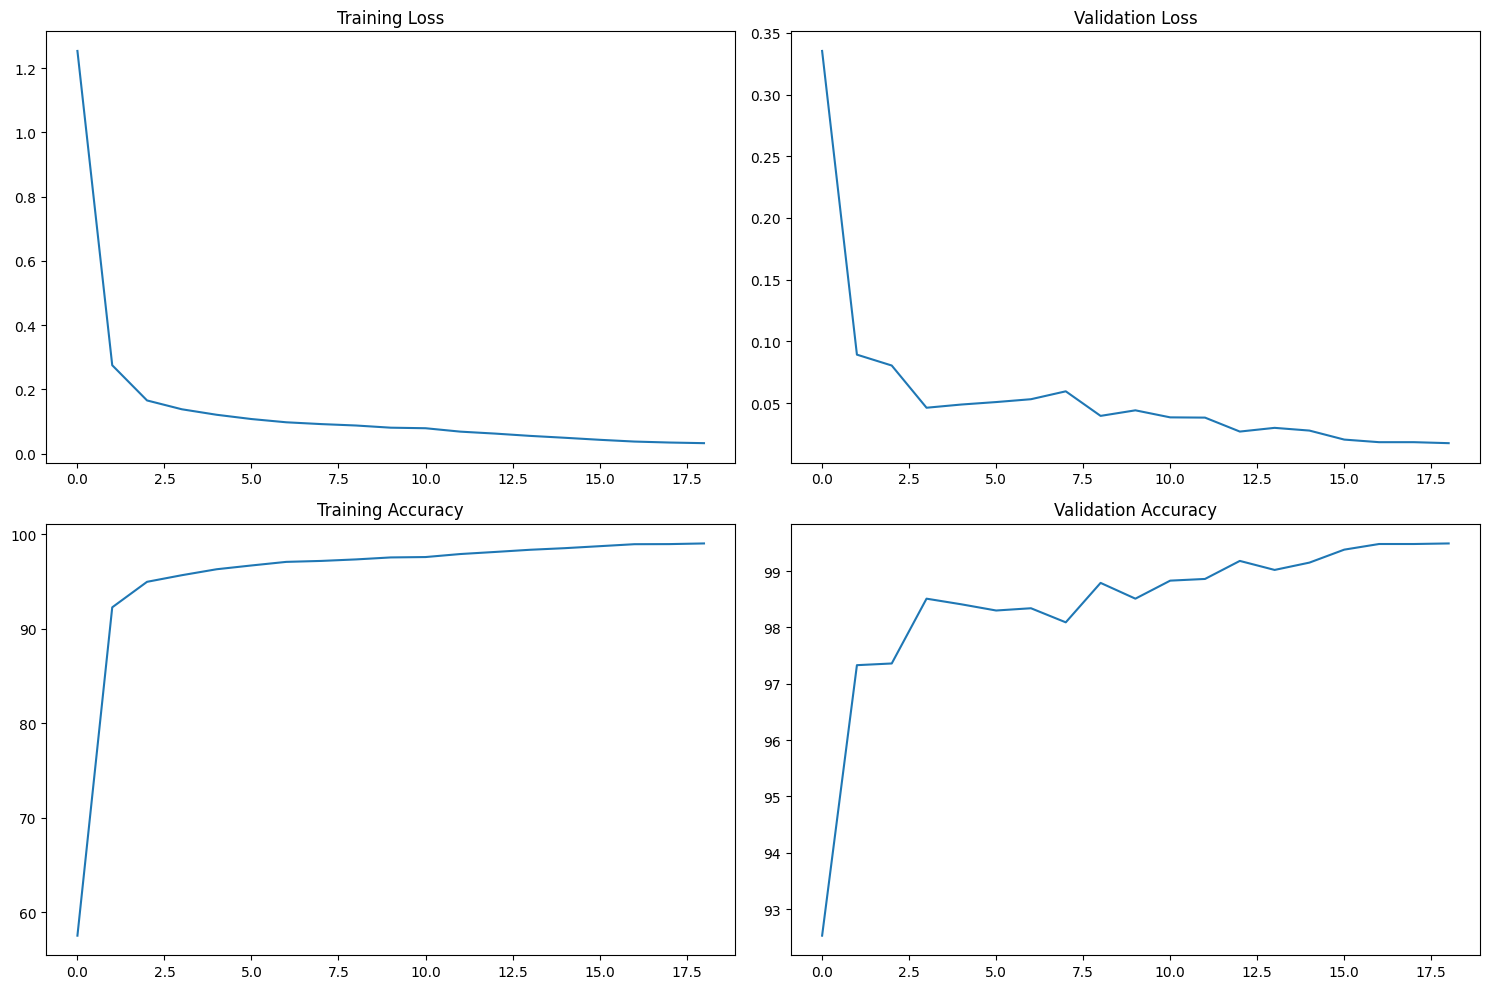

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

# Read the CSV file
df = pd.read_csv('training_log_metrics.csv')

# Extract the metrics
train_loss = df['train_loss']
train_acc = df['train_acc']
val_loss = df['val_loss']
val_acc = df['val_acc']

# Plot the metrics
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(val_loss)
axs[0, 1].set_title("Validation Loss")
axs[1, 1].plot(val_acc)
axs[1, 1].set_title("Validation Accuracy")

plt.tight_layout()
plt.show()